# EDA of Turtle Rescue Challenge

### Table of Contents
1. <a href=#packages-and-data>Packages and Data</a>
2. <a href=#data-cleaning>Data Cleaning</a>
3. <a href=#2nd-table>Adding 2nd Table with Site Category Data</a>
4. <a href=#eda>EDA</a>
4. <a href=#baseline-model>Baseline Model</a>


## Packages and Data

### import packages

In [204]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine, MetaData, Table

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, r2_score, mean_squared_error

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Set random seed 
RSEED = 42
warnings.filterwarnings("ignore")

### import csv data into dataframe

In [21]:
df = pd.read_csv('data/train.csv')
df

,Rescue_ID,Date_TimeCaught,Researcher,CaptureSite,ForagingGround,CaptureMethod,Fisher,LandingSite,Species,Tag_1,...,Lost_Tags,T_Number,CCL_cm,CCW_cm,Weight_Kg,Sex,TurtleCharacteristics,Status,ReleaseSite,Date_TimeRelease
0,2000_RE_0060,2000-12-22,Researcher_25,CaptureSite_0,Ocean,Net,Fisher_1072,LandingSite_CaptureSiteCategory_2,Species_6,CC00147,...,NaN,NaN,64.70,62.60,NaN,Unknown,algae at rear of shell,Released,ReleaseSite_50,22/12/00
1,2001_RE_0187,2001-10-28,Researcher_6,CaptureSite_0,Ocean,Net,Fisher_520,LandingSite_CaptureSiteCategory_2,Species_6,W442,...,NaN,NaN,35.85,31.35,NaN,Unknown,multiple b's on front flippers& a lot of alga...,Released,ReleaseSite_62,28/10/01
2,2001_RE_0197,2001-11-01,Researcher_6,CaptureSite_0,Ocean,Net,Fisher_1669,LandingSite_CaptureSiteCategory_2,Species_5,KE0376,...,NaN,NaN,51.80,49.20,NaN,Unknown,clean,Released,ReleaseSite_50,01/11/01
3,2002_RE_0031,2002-03-11,Researcher_32,CaptureSite_0,Ocean,Net,Fisher_1798,LandingSite_CaptureSiteCategory_2,Species_6,CC00302,...,NaN,NaN,60.50,59.00,NaN,Unknown,1 b 3 CS+ calcerous algae at rear end of shell...,Released,ReleaseSite_50,11/03/02
4,2002_RE_0118,2002-08-08,Researcher_25,CaptureSite_0,Ocean,Beached,Fisher_1918,LandingSite_CaptureSiteCategory_2,Species_5,NotTagged_0113,...,NaN,NaN,34.70,33.00,NaN,Unknown,very lively+ right eye is hanging out + swolle...,Released,ReleaseSite_62,08/08/02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18057,2018_RE_1511,2018-12-18,Researcher_30,CaptureSite_9,Ocean,Net,Fisher_569,LandingSite_CaptureSiteCategory_1,Species_5,KES1828,...,NaN,NaN,57.13,50.57,21.09,Unknown,White calcareous algae on carapace,Released,ReleaseSite_68,18/12/18
18058,2018_RE_1514,2018-12-18,Researcher_30,CaptureSite_9,Ocean,Net,Fisher_125,LandingSite_CaptureSiteCategory_1,Species_6,KES0563,...,KES0416,NaN,42.07,38.37,9.02,Unknown,Calcareous + green algae on carapace\nBarnacle...,Released,ReleaseSite_68,18/12/18
18059,2018_RE_1532,2018-12-24,Researcher_30,CaptureSite_9,Ocean,Net,Fisher_1343,LandingSite_CaptureSiteCategory_1,Species_5,KES1833,...,NaN,NaN,57.20,52.30,NaN,Unknown,Clean turtle,Released,ReleaseSite_68,24/12/18
18060,2018_RE_1533,2018-12-24,Researcher_30,CaptureSite_9,Ocean,Net,Fisher_1551,LandingSite_CaptureSiteCategory_1,Species_5,KES1831,...,NaN,NaN,51.90,48.50,NaN,Unknown,Green algae on carapace\ntip of left supra mis...,Released,ReleaseSite_68,24/12/18


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18062 entries, 0 to 18061
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Rescue_ID              18062 non-null  object 
 1   Date_TimeCaught        18062 non-null  object 
 2   Researcher             18062 non-null  object 
 3   CaptureSite            18062 non-null  object 
 4   ForagingGround         18062 non-null  object 
 5   CaptureMethod          18062 non-null  object 
 6   Fisher                 18062 non-null  object 
 7   LandingSite            18062 non-null  object 
 8   Species                18062 non-null  object 
 9   Tag_1                  17937 non-null  object 
 10  Tag_2                  4911 non-null   object 
 11  Lost_Tags              925 non-null    object 
 12  T_Number               38 non-null     object 
 13  CCL_cm                 18038 non-null  float64
 14  CCW_cm                 18035 non-null  float64
 15  We

## Data Cleaning

### dropping columns unrelated to number and location of turtle captures
##### Tag 1, Tag 2, Lost Tags, Tag Number, Sex, Characteristics, Status, Release Site, Date/Time Release
(for now keeping: Researcher, Fisher, Foraging Ground, Capture Method, Landing Site, Species, Length, Weight, even if later dropped)

In [23]:
columns_drop = ['Tag_1', 'Tag_2', 'Lost_Tags', 'T_Number', 'Sex', 'TurtleCharacteristics', 'ReleaseSite', 'Date_TimeRelease']
df.drop(columns=columns_drop, inplace=True)
df

,Rescue_ID,Date_TimeCaught,Researcher,CaptureSite,ForagingGround,CaptureMethod,Fisher,LandingSite,Species,CCL_cm,CCW_cm,Weight_Kg,Status
0,2000_RE_0060,2000-12-22,Researcher_25,CaptureSite_0,Ocean,Net,Fisher_1072,LandingSite_CaptureSiteCategory_2,Species_6,64.70,62.60,NaN,Released
1,2001_RE_0187,2001-10-28,Researcher_6,CaptureSite_0,Ocean,Net,Fisher_520,LandingSite_CaptureSiteCategory_2,Species_6,35.85,31.35,NaN,Released
2,2001_RE_0197,2001-11-01,Researcher_6,CaptureSite_0,Ocean,Net,Fisher_1669,LandingSite_CaptureSiteCategory_2,Species_5,51.80,49.20,NaN,Released
3,2002_RE_0031,2002-03-11,Researcher_32,CaptureSite_0,Ocean,Net,Fisher_1798,LandingSite_CaptureSiteCategory_2,Species_6,60.50,59.00,NaN,Released
4,2002_RE_0118,2002-08-08,Researcher_25,CaptureSite_0,Ocean,Beached,Fisher_1918,LandingSite_CaptureSiteCategory_2,Species_5,34.70,33.00,NaN,Released
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18057,2018_RE_1511,2018-12-18,Researcher_30,CaptureSite_9,Ocean,Net,Fisher_569,LandingSite_CaptureSiteCategory_1,Species_5,57.13,50.57,21.09,Released
18058,2018_RE_1514,2018-12-18,Researcher_30,CaptureSite_9,Ocean,Net,Fisher_125,LandingSite_CaptureSiteCategory_1,Species_6,42.07,38.37,9.02,Released
18059,2018_RE_1532,2018-12-24,Researcher_30,CaptureSite_9,Ocean,Net,Fisher_1343,LandingSite_CaptureSiteCategory_1,Species_5,57.20,52.30,NaN,Released
18060,2018_RE_1533,2018-12-24,Researcher_30,CaptureSite_9,Ocean,Net,Fisher_1551,LandingSite_CaptureSiteCategory_1,Species_5,51.90,48.50,NaN,Released


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18062 entries, 0 to 18061
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Rescue_ID        18062 non-null  object 
 1   Date_TimeCaught  18062 non-null  object 
 2   Researcher       18062 non-null  object 
 3   CaptureSite      18062 non-null  object 
 4   ForagingGround   18062 non-null  object 
 5   CaptureMethod    18062 non-null  object 
 6   Fisher           18062 non-null  object 
 7   LandingSite      18062 non-null  object 
 8   Species          18062 non-null  object 
 9   CCL_cm           18038 non-null  float64
 10  CCW_cm           18035 non-null  float64
 11  Weight_Kg        12653 non-null  float64
 12  Status           14429 non-null  object 
dtypes: float64(3), object(10)
memory usage: 1.8+ MB


In [25]:
df.describe()

,CCL_cm,CCW_cm,Weight_Kg
count,18038.000000,18035.000000,12653.000000
mean,43.090390,40.253904,9.850731
std,11.004251,9.933058,9.737378
min,2.000000,2.000000,0.020000
25%,36.330000,34.000000,5.000000
50%,41.300000,39.300000,7.500000
75%,47.000000,44.100000,10.800000
max,122.750000,106.000000,140.000000


In [26]:
df.isna().sum()

Rescue_ID             0
Date_TimeCaught       0
Researcher            0
CaptureSite           0
ForagingGround        0
CaptureMethod         0
Fisher                0
LandingSite           0
Species               0
CCL_cm               24
CCW_cm               27
Weight_Kg          5409
Status             3633
dtype: int64

#### (CCL_cm, CCW_cm and Weight_Kg have NaNs that need to be filled in!)

In [27]:
df.nunique()

Rescue_ID          18062
Date_TimeCaught     5237
Researcher            35
CaptureSite           29
ForagingGround         3
CaptureMethod         15
Fisher              2085
LandingSite            5
Species                8
CCL_cm              1338
CCW_cm              1262
Weight_Kg           1937
Status               439
dtype: int64

In [28]:
df['Status'].unique()

array(['Released', ' 2smb 3LLS& 1sm b R supra',
       ' b scar 4RMS& 2LLS& 4LLS',
       ' sm patches of calcerous algae on shell and supras',
       ' b join 3/4 LLS', nan, 'Admitted', ' chips on RM',
       ' tip of RS CS missing',
       " quite large piece missing from 1 + 2 scale area on LFF - possibly old tagging+ but unlikley that tagged there and piece is large+ maybe old wound.  a lot of small b's on flesh",
       ' green algae on scutes',
       ' no other major physical characteristics',
       ' light green algae on scutes', ' no other major characteristics',
       ' 6 LLS& small notch in the joints between both 10th and 11th MS',
       ' B scar on 1st CS', ' notch on LRF',
       ' few small barnacles on carapace', ' barnacles on ???',
       ' tiny barnacles on plastron', ' green algae on rear carapace',
       ' small barnacles on neck', ' small barnacles on flippers',
       ' RSCS tip missing', ' green algae on carapace',
       ' 7+ 9 + 10 LM scutes have some chip

In [29]:
df['Status'].value_counts()

Status
Released                                          13610
Admitted                                            292
Not_Recorded                                         28
 shell is beginning to flake                          7
 green algae on carapace                              7
                                                  ...  
 barnacles on plastron (removed)                      1
 notches on RMS                                       1
 small barnacles around neck and rear flippers        1
 5 RLS                                                1
 barnacles on plastron                                1
Name: count, Length: 439, dtype: int64

In [30]:
status_nan = df[df['Status'].isna()]
status_nan

,Rescue_ID,Date_TimeCaught,Researcher,CaptureSite,ForagingGround,CaptureMethod,Fisher,LandingSite,Species,CCL_cm,CCW_cm,Weight_Kg,Status
17,2008_RE_0022,2008-01-23,Researcher_30,CaptureSite_0,Ocean,Net,Fisher_257,LandingSite_CaptureSiteCategory_2,Species_5,38.1,38.2,NaN,NaN
18,2009_RE_0014,2009-01-06,Researcher_30,CaptureSite_0,Ocean,Beached,Fisher_2108,LandingSite_CaptureSiteCategory_2,Species_5,45.6,43.7,NaN,NaN
19,2009_RE_0150,2009-02-09,Researcher_30,CaptureSite_0,Ocean,By Hand,Fisher_325,LandingSite_CaptureSiteCategory_2,Species_5,43.4,40.0,NaN,NaN
20,2009_RE_0183,2009-02-17,Researcher_30,CaptureSite_0,Ocean,Beached,Fisher_1424,LandingSite_CaptureSiteCategory_2,Species_6,24.7,24.5,1.7,NaN
21,2009_RE_0390,2009-06-25,Researcher_30,CaptureSite_0,Ocean,Net,Fisher_1938,LandingSite_CaptureSiteCategory_2,Species_6,31.0,28.9,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16291,2011_RE_0805,2011-09-23,Researcher_20,CaptureSite_9,Ocean,Net,Fisher_1500,LandingSite_CaptureSiteCategory_1,Species_6,33.2,30.9,4.5,NaN
16292,2011_RE_0806,2011-09-23,Researcher_20,CaptureSite_9,Ocean,Net,Fisher_1550,LandingSite_CaptureSiteCategory_1,Species_5,43.3,42.1,10.5,NaN
16293,2011_RE_0807,2011-09-23,Researcher_20,CaptureSite_9,Ocean,Net,Fisher_1550,LandingSite_CaptureSiteCategory_1,Species_5,103.4,100.0,NaN,NaN
16294,2011_RE_0809,2011-09-23,Researcher_20,CaptureSite_9,Ocean,Net,Fisher_1550,LandingSite_CaptureSiteCategory_1,Species_5,41.1,38.6,8.5,NaN


In [31]:
df['ForagingGround'].unique()

array(['Ocean', 'Creek', 'creek'], dtype=object)

In [32]:
df['CaptureMethod'].unique()

array(['Net', 'Beached', 'Not_Recorded', 'Longline', 'By Hand',
       'Collected Floater', 'Jarife', 'stranded', 'net', 'Fish Trap',
       'Uzio', 'Speargun', 'by hand', 'longline', 'jarife'], dtype=object)

#### ForagingGround and CaptureMethod need case consistency

In [33]:
df['ForagingGround'] = df['ForagingGround'].str.lower()
df['CaptureMethod'] = df['CaptureMethod'].str.lower()

In [34]:
df['CaptureMethod'].unique()

array(['net', 'beached', 'not_recorded', 'longline', 'by hand',
       'collected floater', 'jarife', 'stranded', 'fish trap', 'uzio',
       'speargun'], dtype=object)

In [35]:
df['ForagingGround'].unique()

array(['ocean', 'creek'], dtype=object)

### Dealing with Missing Values in Length, Width, Weight

##### Finding Mean and Median of Length and Width by Species

In [36]:
df['Species'].value_counts()

Species
Species_5    11097
Species_6     6882
Species_4       50
Species_7       21
Species_0        7
Species_1        2
Species_2        2
Species_3        1
Name: count, dtype: int64

In [37]:
df.groupby('Species').describe()

CCL_cm                                                              
             count       mean        std   min     25%    50%     75%     max   
Species                                                                         
Species_0      7.0  44.171429  19.973959   2.0  43.750  48.50  53.250   64.70  \
Species_1      2.0  60.550000  82.802204   2.0  31.275  60.55  89.825  119.10   
Species_2      2.0  43.850000   1.343503  42.9  43.375  43.85  44.325   44.80   
Species_3      1.0  38.500000        NaN  38.5  38.500  38.50  38.500   38.50   
Species_4     50.0  84.579000   7.369168  66.7  80.150  85.10  89.575  102.30   
Species_5  11079.0  46.610660  10.598307   2.0  40.400  43.90  50.300  122.75   
Species_6   6876.0  37.108383   8.044283   3.8  32.500  35.70  39.800   90.50   
Species_7     21.0  43.917619  25.468438   4.0  23.400  52.10  65.000   72.50   

            CCW_cm             ...                Weight_Kg               
             count       mean  ...     75%    max     count        mean   
Species                        ...                                        
Species_0      7.0  41.385714  ...  49.050   58.0       1.0    0.030000  \
Species_1      2.0  43.250000  ...  63.875   84.5       1.0  121.400000   
Species_2      2.0  43.550000  ...  43.975   44.4       2.0   10.585000   
Species_3      1.0  35.800000  ...  35.800   35.8       1.0    6.600000   
Species_4     50.0  78.853800  ...  82.575   93.8      43.0   76.608605   
Species_5  11076.0  43.799567  ...  46.500  106.0    6415.0   12.432265   
Species_6   6876.0  34.244706  ...  36.800   82.1    6175.0    6.654633   
Species_7     21.0  45.084286  ...  67.800   71.0      15.0   23.506000   

                                                                   
                 std     min       25%      50%       75%     max  
Species                                                            
Species_0        NaN    0.03    0.0300    0.030    0.0300    0.03  
Species_1        NaN  121.40  121.4000  121.400  121.4000  121.40  
Species_2   0.544472   10.20   10.3925   10.585   10.7775   10.97  
Species_3        NaN    6.60    6.6000    6.600    6.6000    6.60  
Species_4  23.759768    0.03   67.6500   74.810   90.5000  124.80  
Species_5  10.538680    0.03    7.3900    9.500   13.5000  140.00  
Species_6   4.858940    0.02    4.0000    5.350    7.5000   72.00  
Species_7  18.840056    0.10    7.7250   22.360   36.1200   60.95  

[8 rows x 24 columns]

In [38]:
# Group by 'Species' column and calculate average and median for 'CCL_cm' and 'CCW_cm'
species_stats = df.groupby('Species').agg({'CCL_cm': ['mean', 'median'], 'CCW_cm': ['mean', 'median']})

# Rename columns for clarity
species_stats.columns = ['CCL_mean', 'CCL_median', 'CCW_mean', 'CCW_median']

species_stats

,CCL_mean,CCL_median,CCW_mean,CCW_median
Species,,,,
Species_0,44.171429,48.50,41.385714,45.20
Species_1,60.550000,60.55,43.250000,43.25
Species_2,43.850000,43.85,43.550000,43.55
Species_3,38.500000,38.50,35.800000,35.80
Species_4,84.579000,85.10,78.853800,78.95
Species_5,46.610660,43.90,43.799567,41.80
Species_6,37.108383,35.70,34.244706,33.20
Species_7,43.917619,52.10,45.084286,54.90


In [39]:
# Fill NaN values with the mean of each species
df['CCL_cm'] = df.groupby('Species')['CCL_cm'].transform(lambda x: x.fillna(x.mean()))
df['CCW_cm'] = df.groupby('Species')['CCW_cm'].transform(lambda x: x.fillna(x.mean()))
df.isna().sum()

Rescue_ID             0
Date_TimeCaught       0
Researcher            0
CaptureSite           0
ForagingGround        0
CaptureMethod         0
Fisher                0
LandingSite           0
Species               0
CCL_cm                0
CCW_cm                0
Weight_Kg          5409
Status             3633
dtype: int64

### here, I discovered some very large turtles weirdly had tiny weights (0.030kg came up a bunch?)

In [40]:
df[df['CCW_cm'] > 75]

,Rescue_ID,Date_TimeCaught,Researcher,CaptureSite,ForagingGround,CaptureMethod,Fisher,LandingSite,Species,CCL_cm,CCW_cm,Weight_Kg,Status
34,2011_RE_0491,2011-06-22,Researcher_20,CaptureSite_0,ocean,net,Fisher_513,LandingSite_CaptureSiteCategory_2,Species_5,93.4,89.1,70.00,NaN
75,2016_RE_0393,2016-05-12,Researcher_20,CaptureSite_0,ocean,beached,Fisher_44,LandingSite_CaptureSiteCategory_2,Species_5,97.4,93.2,93.60,Released
121,2008_RE_0441,2008-09-19,Researcher_30,CaptureSite_1,ocean,net,Fisher_1550,LandingSite_CaptureSiteCategory_2,Species_5,101.0,91.4,NaN,no other major characteristics
122,2008_RE_0444,2008-09-21,Researcher_30,CaptureSite_1,ocean,net,Fisher_1550,LandingSite_CaptureSiteCategory_2,Species_5,92.8,81.5,NaN,6 LLS& small notch in the joints between both...
127,2008_RE_0518,2008-10-12,Researcher_30,CaptureSite_1,ocean,net,Fisher_1757,LandingSite_CaptureSiteCategory_2,Species_5,99.2,88.7,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17383,2016_RE_0449,2016-06-10,Researcher_20,CaptureSite_9,ocean,beached,Fisher_863,LandingSite_CaptureSiteCategory_1,Species_5,90.0,84.0,80.80,Admitted
17474,2016_RE_1132,2016-11-18,Researcher_20,CaptureSite_9,ocean,jarife,Fisher_92,LandingSite_CaptureSiteCategory_1,Species_5,100.6,95.7,131.40,Released
17475,2016_RE_1138,2016-11-19,Researcher_20,CaptureSite_9,ocean,net,Fisher_92,LandingSite_CaptureSiteCategory_1,Species_5,83.6,77.9,65.20,Released
17585,2017_RE_0455,2017-04-09,Researcher_30,CaptureSite_9,ocean,collected floater,Fisher_1551,LandingSite_CaptureSiteCategory_1,Species_5,100.0,95.6,0.03,Admitted


In [41]:
df[df['Weight_Kg'] < .1]

,Rescue_ID,Date_TimeCaught,Researcher,CaptureSite,ForagingGround,CaptureMethod,Fisher,LandingSite,Species,CCL_cm,CCW_cm,Weight_Kg,Status
1083,2016_RE_0423,2016-05-28,Researcher_20,CaptureSite_10,ocean,beached,Fisher_87,LandingSite_CaptureSiteCategory_2,Species_6,5.7,6.1,0.03,Released
1335,2018_RE_0387,2018-04-02,Researcher_13,CaptureSite_10,ocean,beached,Fisher_1284,LandingSite_CaptureSiteCategory_2,Species_6,8.1,7.2,0.03,Released
2054,2014_RE_0648,2014-07-04,Researcher_20,CaptureSite_12,ocean,beached,Fisher_264,LandingSite_CaptureSiteCategory_2,Species_6,8.6,8.4,0.08,Released
2167,2017_RE_0702,2017-06-13,Researcher_20,CaptureSite_12,ocean,net,Fisher_1824,LandingSite_CaptureSiteCategory_2,Species_5,6.0,6.0,0.05,Released
4908,2017_RE_0548,2017-05-08,Researcher_20,CaptureSite_15,creek,net,Fisher_92,LandingSite_CaptureSiteCategory_0,Species_0,2.0,2.0,0.03,Released
6583,2010_RE_0672,2010-08-26,Researcher_30,CaptureSite_19,ocean,beached,Fisher_1480,LandingSite_CaptureSiteCategory_2,Species_5,7.0,6.4,0.05,NaN
6828,2017_RE_0881,2017-08-06,Researcher_30,CaptureSite_19,ocean,net,Fisher_1901,LandingSite_CaptureSiteCategory_2,Species_4,87.5,84.5,0.03,Admitted
7739,2012_RE_0776,2012-06-28,Researcher_20,CaptureSite_21,creek,net,Fisher_1115,LandingSite_CaptureSiteCategory_0,Species_6,5.9,5.5,0.04,Released
10392,2011_RE_0328,2011-05-03,Researcher_20,CaptureSite_24,ocean,beached,Fisher_1803,LandingSite_CaptureSiteCategory_2,Species_6,5.4,5.2,0.02,NaN
12942,2017_RE_0478,2017-04-19,Researcher_20,CaptureSite_25,creek,net,Fisher_1478,LandingSite_CaptureSiteCategory_0,Species_6,6.0,5.6,0.03,tiny barnacles on plastron


In [42]:
# Replace 0.03 with NaN in the 'Weight_Kg' column
df['Weight_Kg'].replace(0.03, np.nan, inplace=True)
df[df['Weight_Kg'] == 0.030]

,Rescue_ID,Date_TimeCaught,Researcher,CaptureSite,ForagingGround,CaptureMethod,Fisher,LandingSite,Species,CCL_cm,CCW_cm,Weight_Kg,Status


In [43]:
df.isna().sum()

Rescue_ID             0
Date_TimeCaught       0
Researcher            0
CaptureSite           0
ForagingGround        0
CaptureMethod         0
Fisher                0
LandingSite           0
Species               0
CCL_cm                0
CCW_cm                0
Weight_Kg          5416
Status             3633
dtype: int64

In [44]:
# fill missing weights based on similar lengths and widths within a percentage margin (start 10%?)
def fill_missing_weights3(df, margin=0.10):
    # iterate rows with missing weights
    for index, row in df[df['Weight_Kg'].isnull()].iterrows():
        # lower/upper bounds for length/width
        lower_length = row['CCL_cm'] * (1 - margin)
        upper_length = row['CCL_cm'] * (1 + margin)
        lower_width = row['CCW_cm'] * (1 - margin)
        upper_width = row['CCW_cm'] * (1 + margin)
        
        # store turtles with lengths/widths within margins
        similar_turtles = df[(df['CCL_cm'] >= lower_length) & (df['CCL_cm'] <= upper_length) &
                             (df['CCW_cm'] >= lower_width) & (df['CCW_cm'] <= upper_width) &
                             df['Weight_Kg'].notnull()]
        
        if not similar_turtles.empty:
            # average weight of similar turtles
            avg_weight = similar_turtles['Weight_Kg'].mean()
            # fill missing weight with mean
            df.at[index, 'Weight_Kg'] = avg_weight

fill_missing_weights3(df, margin=0.10)
df.isna().sum()

Rescue_ID             0
Date_TimeCaught       0
Researcher            0
CaptureSite           0
ForagingGround        0
CaptureMethod         0
Fisher                0
LandingSite           0
Species               0
CCL_cm                0
CCW_cm                0
Weight_Kg             6
Status             3633
dtype: int64

In [45]:
fill_missing_weights3(df, margin=0.20)
df.isna().sum()

Rescue_ID             0
Date_TimeCaught       0
Researcher            0
CaptureSite           0
ForagingGround        0
CaptureMethod         0
Fisher                0
LandingSite           0
Species               0
CCL_cm                0
CCW_cm                0
Weight_Kg             3
Status             3633
dtype: int64

In [46]:
df[df['Weight_Kg'].isnull()]

,Rescue_ID,Date_TimeCaught,Researcher,CaptureSite,ForagingGround,CaptureMethod,Fisher,LandingSite,Species,CCL_cm,CCW_cm,Weight_Kg,Status
4908,2017_RE_0548,2017-05-08,Researcher_20,CaptureSite_15,creek,net,Fisher_92,LandingSite_CaptureSiteCategory_0,Species_0,2.0,2.0,NaN,Released
6962,2008_RE_0007,2008-01-06,Researcher_10,CaptureSite_2,ocean,net,Fisher_1757,LandingSite_CaptureSiteCategory_2,Species_5,2.0,2.0,NaN,NaN
8580,2003_RE_0545,2003-06-26,Researcher_30,CaptureSite_23,creek,net,Fisher_1909,LandingSite_CaptureSiteCategory_0,Species_1,2.0,2.0,NaN,Released


In [47]:
df[df['CCW_cm'] < 4]

,Rescue_ID,Date_TimeCaught,Researcher,CaptureSite,ForagingGround,CaptureMethod,Fisher,LandingSite,Species,CCL_cm,CCW_cm,Weight_Kg,Status
914,2002_RE_0058,2002-05-11,Researcher_32,CaptureSite_10,ocean,net,Fisher_662,LandingSite_CaptureSiteCategory_2,Species_6,3.8,3.6,0.268308,Released
1597,2015_RE_0847,2015-07-15,Researcher_20,CaptureSite_11,creek,net,Fisher_1478,LandingSite_CaptureSiteCategory_0,Species_5,4.3,3.6,0.100000,Released
1598,2015_RE_0848,2015-07-15,Researcher_20,CaptureSite_11,creek,net,Fisher_1478,LandingSite_CaptureSiteCategory_0,Species_5,4.6,3.6,0.100000,Released
4908,2017_RE_0548,2017-05-08,Researcher_20,CaptureSite_15,creek,net,Fisher_92,LandingSite_CaptureSiteCategory_0,Species_0,2.0,2.0,NaN,Released
6962,2008_RE_0007,2008-01-06,Researcher_10,CaptureSite_2,ocean,net,Fisher_1757,LandingSite_CaptureSiteCategory_2,Species_5,2.0,2.0,NaN,NaN
8580,2003_RE_0545,2003-06-26,Researcher_30,CaptureSite_23,creek,net,Fisher_1909,LandingSite_CaptureSiteCategory_0,Species_1,2.0,2.0,NaN,Released
9989,2015_RE_0846,2015-07-14,Researcher_20,CaptureSite_23,creek,net,Fisher_1108,LandingSite_CaptureSiteCategory_0,Species_5,4.3,3.5,0.100000,Released


In [48]:
# Replace missing weight values with 0.08
df.loc[df['Weight_Kg'].isnull(), 'Weight_Kg'] = 0.08
df.isna().sum()

Rescue_ID             0
Date_TimeCaught       0
Researcher            0
CaptureSite           0
ForagingGround        0
CaptureMethod         0
Fisher                0
LandingSite           0
Species               0
CCL_cm                0
CCW_cm                0
Weight_Kg             0
Status             3633
dtype: int64

## Considering the Date/Time Column
Deciding that Month is specific enough, to drop individual dates, so a column for year and a column for month is fine to me

In [49]:
df['Date_TimeCaught']

0        2000-12-22
1        2001-10-28
2        2001-11-01
3        2002-03-11
4        2002-08-08
            ...    
18057    2018-12-18
18058    2018-12-18
18059    2018-12-24
18060    2018-12-24
18061    2018-12-28
Name: Date_TimeCaught, Length: 18062, dtype: object

In [50]:
df['Date_TimeCaught'].dtype

dtype('O')

In [51]:
# extract year and month from 'Date_TimeCaught' column (formatted as string!)
df['year_caught'] = df['Date_TimeCaught'].str[:4].astype(int)
df['month_caught'] = df['Date_TimeCaught'].str[5:7].astype(int)

df

,Rescue_ID,Date_TimeCaught,Researcher,CaptureSite,ForagingGround,CaptureMethod,Fisher,LandingSite,Species,CCL_cm,CCW_cm,Weight_Kg,Status,year_caught,month_caught
0,2000_RE_0060,2000-12-22,Researcher_25,CaptureSite_0,ocean,net,Fisher_1072,LandingSite_CaptureSiteCategory_2,Species_6,64.70,62.60,32.262274,Released,2000,12
1,2001_RE_0187,2001-10-28,Researcher_6,CaptureSite_0,ocean,net,Fisher_520,LandingSite_CaptureSiteCategory_2,Species_6,35.85,31.35,5.014822,Released,2001,10
2,2001_RE_0197,2001-11-01,Researcher_6,CaptureSite_0,ocean,net,Fisher_1669,LandingSite_CaptureSiteCategory_2,Species_5,51.80,49.20,16.349537,Released,2001,11
3,2002_RE_0031,2002-03-11,Researcher_32,CaptureSite_0,ocean,net,Fisher_1798,LandingSite_CaptureSiteCategory_2,Species_6,60.50,59.00,27.349175,Released,2002,3
4,2002_RE_0118,2002-08-08,Researcher_25,CaptureSite_0,ocean,beached,Fisher_1918,LandingSite_CaptureSiteCategory_2,Species_5,34.70,33.00,5.206052,Released,2002,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18057,2018_RE_1511,2018-12-18,Researcher_30,CaptureSite_9,ocean,net,Fisher_569,LandingSite_CaptureSiteCategory_1,Species_5,57.13,50.57,21.090000,Released,2018,12
18058,2018_RE_1514,2018-12-18,Researcher_30,CaptureSite_9,ocean,net,Fisher_125,LandingSite_CaptureSiteCategory_1,Species_6,42.07,38.37,9.020000,Released,2018,12
18059,2018_RE_1532,2018-12-24,Researcher_30,CaptureSite_9,ocean,net,Fisher_1343,LandingSite_CaptureSiteCategory_1,Species_5,57.20,52.30,20.461698,Released,2018,12
18060,2018_RE_1533,2018-12-24,Researcher_30,CaptureSite_9,ocean,net,Fisher_1551,LandingSite_CaptureSiteCategory_1,Species_5,51.90,48.50,15.618496,Released,2018,12


In [52]:
df['Fisher'].value_counts()

Fisher
Fisher_1478    1499
Fisher_92       570
Fisher_1550     448
Fisher_1551     435
Fisher_1472     383
               ... 
Fisher_611        1
Fisher_408        1
Fisher_107        1
Fisher_294        1
Fisher_569        1
Name: count, Length: 2085, dtype: int64

### Further consolidating data, dropping other columns, merging length/width

deciding to drop Rescue_ID, CaptureMethod, Researcher and now we no longer need Species

In [53]:
columns_drop = ['Species', 'Rescue_ID', 'CaptureMethod', 'Researcher']
df.drop(columns=columns_drop, inplace=True)
df

,Date_TimeCaught,CaptureSite,ForagingGround,Fisher,LandingSite,CCL_cm,CCW_cm,Weight_Kg,Status,year_caught,month_caught
0,2000-12-22,CaptureSite_0,ocean,Fisher_1072,LandingSite_CaptureSiteCategory_2,64.70,62.60,32.262274,Released,2000,12
1,2001-10-28,CaptureSite_0,ocean,Fisher_520,LandingSite_CaptureSiteCategory_2,35.85,31.35,5.014822,Released,2001,10
2,2001-11-01,CaptureSite_0,ocean,Fisher_1669,LandingSite_CaptureSiteCategory_2,51.80,49.20,16.349537,Released,2001,11
3,2002-03-11,CaptureSite_0,ocean,Fisher_1798,LandingSite_CaptureSiteCategory_2,60.50,59.00,27.349175,Released,2002,3
4,2002-08-08,CaptureSite_0,ocean,Fisher_1918,LandingSite_CaptureSiteCategory_2,34.70,33.00,5.206052,Released,2002,8
...,...,...,...,...,...,...,...,...,...,...,...
18057,2018-12-18,CaptureSite_9,ocean,Fisher_569,LandingSite_CaptureSiteCategory_1,57.13,50.57,21.090000,Released,2018,12
18058,2018-12-18,CaptureSite_9,ocean,Fisher_125,LandingSite_CaptureSiteCategory_1,42.07,38.37,9.020000,Released,2018,12
18059,2018-12-24,CaptureSite_9,ocean,Fisher_1343,LandingSite_CaptureSiteCategory_1,57.20,52.30,20.461698,Released,2018,12
18060,2018-12-24,CaptureSite_9,ocean,Fisher_1551,LandingSite_CaptureSiteCategory_1,51.90,48.50,15.618496,Released,2018,12


In [54]:
# Calculate area from CCL_cm and CCW_cm
df['area_sqcm'] = (df['CCL_cm'] * df['CCW_cm']) / 100

# Drop the original columns
df.drop(['CCL_cm', 'CCW_cm'], axis=1, inplace=True)
df

,Date_TimeCaught,CaptureSite,ForagingGround,Fisher,LandingSite,Weight_Kg,Status,year_caught,month_caught,area_sqcm
0,2000-12-22,CaptureSite_0,ocean,Fisher_1072,LandingSite_CaptureSiteCategory_2,32.262274,Released,2000,12,40.502200
1,2001-10-28,CaptureSite_0,ocean,Fisher_520,LandingSite_CaptureSiteCategory_2,5.014822,Released,2001,10,11.238975
2,2001-11-01,CaptureSite_0,ocean,Fisher_1669,LandingSite_CaptureSiteCategory_2,16.349537,Released,2001,11,25.485600
3,2002-03-11,CaptureSite_0,ocean,Fisher_1798,LandingSite_CaptureSiteCategory_2,27.349175,Released,2002,3,35.695000
4,2002-08-08,CaptureSite_0,ocean,Fisher_1918,LandingSite_CaptureSiteCategory_2,5.206052,Released,2002,8,11.451000
...,...,...,...,...,...,...,...,...,...,...
18057,2018-12-18,CaptureSite_9,ocean,Fisher_569,LandingSite_CaptureSiteCategory_1,21.090000,Released,2018,12,28.890641
18058,2018-12-18,CaptureSite_9,ocean,Fisher_125,LandingSite_CaptureSiteCategory_1,9.020000,Released,2018,12,16.142259
18059,2018-12-24,CaptureSite_9,ocean,Fisher_1343,LandingSite_CaptureSiteCategory_1,20.461698,Released,2018,12,29.915600
18060,2018-12-24,CaptureSite_9,ocean,Fisher_1551,LandingSite_CaptureSiteCategory_1,15.618496,Released,2018,12,25.171500


<a id="2nd-table"></a>

## Exploring CaptureSite_category.csv to see if Category means LandingSite and Type means ForagingGround Type 

In [55]:
# Loading the titanic dataset
csc = pd.read_csv('data/CaptureSite_category.csv')
csc

,CaptureSite,CaptureSiteCategory,Type
0,CaptureSite_0,CaptureSiteCategory_2,Type_1
1,CaptureSite_1,CaptureSiteCategory_2,Type_1
2,CaptureSite_10,CaptureSiteCategory_2,Type_1
3,CaptureSite_11,CaptureSiteCategory_0,Type_0
4,CaptureSite_12,CaptureSiteCategory_2,Type_1
5,CaptureSite_13,CaptureSiteCategory_2,Type_1
6,CaptureSite_14,CaptureSiteCategory_4,Type_0
7,CaptureSite_15,CaptureSiteCategory_0,Type_0
8,CaptureSite_16,CaptureSiteCategory_4,Type_0
9,CaptureSite_17,CaptureSiteCategory_4,Type_0


In [56]:
# Merge 'df' with 'csc' on the 'CaptureSite' column
df = df.merge(csc[['CaptureSite', 'CaptureSiteCategory', 'Type']], on='CaptureSite', how='left')

In [57]:
df

,Date_TimeCaught,CaptureSite,ForagingGround,Fisher,LandingSite,Weight_Kg,Status,year_caught,month_caught,area_sqcm,CaptureSiteCategory,Type
0,2000-12-22,CaptureSite_0,ocean,Fisher_1072,LandingSite_CaptureSiteCategory_2,32.262274,Released,2000,12,40.502200,CaptureSiteCategory_2,Type_1
1,2001-10-28,CaptureSite_0,ocean,Fisher_520,LandingSite_CaptureSiteCategory_2,5.014822,Released,2001,10,11.238975,CaptureSiteCategory_2,Type_1
2,2001-11-01,CaptureSite_0,ocean,Fisher_1669,LandingSite_CaptureSiteCategory_2,16.349537,Released,2001,11,25.485600,CaptureSiteCategory_2,Type_1
3,2002-03-11,CaptureSite_0,ocean,Fisher_1798,LandingSite_CaptureSiteCategory_2,27.349175,Released,2002,3,35.695000,CaptureSiteCategory_2,Type_1
4,2002-08-08,CaptureSite_0,ocean,Fisher_1918,LandingSite_CaptureSiteCategory_2,5.206052,Released,2002,8,11.451000,CaptureSiteCategory_2,Type_1
...,...,...,...,...,...,...,...,...,...,...,...,...
18057,2018-12-18,CaptureSite_9,ocean,Fisher_569,LandingSite_CaptureSiteCategory_1,21.090000,Released,2018,12,28.890641,CaptureSiteCategory_1,Type_1
18058,2018-12-18,CaptureSite_9,ocean,Fisher_125,LandingSite_CaptureSiteCategory_1,9.020000,Released,2018,12,16.142259,CaptureSiteCategory_1,Type_1
18059,2018-12-24,CaptureSite_9,ocean,Fisher_1343,LandingSite_CaptureSiteCategory_1,20.461698,Released,2018,12,29.915600,CaptureSiteCategory_1,Type_1
18060,2018-12-24,CaptureSite_9,ocean,Fisher_1551,LandingSite_CaptureSiteCategory_1,15.618496,Released,2018,12,25.171500,CaptureSiteCategory_1,Type_1


In [58]:
# Replace the prefix "LandingSite_" with an empty string in the 'LandingSite' column
df['LandingSite'] = df['LandingSite'].str.replace('LandingSite_', '')
df

,Date_TimeCaught,CaptureSite,ForagingGround,Fisher,LandingSite,Weight_Kg,Status,year_caught,month_caught,area_sqcm,CaptureSiteCategory,Type
0,2000-12-22,CaptureSite_0,ocean,Fisher_1072,CaptureSiteCategory_2,32.262274,Released,2000,12,40.502200,CaptureSiteCategory_2,Type_1
1,2001-10-28,CaptureSite_0,ocean,Fisher_520,CaptureSiteCategory_2,5.014822,Released,2001,10,11.238975,CaptureSiteCategory_2,Type_1
2,2001-11-01,CaptureSite_0,ocean,Fisher_1669,CaptureSiteCategory_2,16.349537,Released,2001,11,25.485600,CaptureSiteCategory_2,Type_1
3,2002-03-11,CaptureSite_0,ocean,Fisher_1798,CaptureSiteCategory_2,27.349175,Released,2002,3,35.695000,CaptureSiteCategory_2,Type_1
4,2002-08-08,CaptureSite_0,ocean,Fisher_1918,CaptureSiteCategory_2,5.206052,Released,2002,8,11.451000,CaptureSiteCategory_2,Type_1
...,...,...,...,...,...,...,...,...,...,...,...,...
18057,2018-12-18,CaptureSite_9,ocean,Fisher_569,CaptureSiteCategory_1,21.090000,Released,2018,12,28.890641,CaptureSiteCategory_1,Type_1
18058,2018-12-18,CaptureSite_9,ocean,Fisher_125,CaptureSiteCategory_1,9.020000,Released,2018,12,16.142259,CaptureSiteCategory_1,Type_1
18059,2018-12-24,CaptureSite_9,ocean,Fisher_1343,CaptureSiteCategory_1,20.461698,Released,2018,12,29.915600,CaptureSiteCategory_1,Type_1
18060,2018-12-24,CaptureSite_9,ocean,Fisher_1551,CaptureSiteCategory_1,15.618496,Released,2018,12,25.171500,CaptureSiteCategory_1,Type_1


In [59]:
# Create a new DataFrame to store rows with different values in 'LandingSite' and 'CaptureSiteCategory'
different_sites_df = df[df['LandingSite'] != df['CaptureSiteCategory']]
different_sites_df

,Date_TimeCaught,CaptureSite,ForagingGround,Fisher,LandingSite,Weight_Kg,Status,year_caught,month_caught,area_sqcm,CaptureSiteCategory,Type


### Landing Site and Capture Site Category are synonymous!!

In [60]:
df.drop('CaptureSiteCategory', axis=1, inplace=True)
df

,Date_TimeCaught,CaptureSite,ForagingGround,Fisher,LandingSite,Weight_Kg,Status,year_caught,month_caught,area_sqcm,Type
0,2000-12-22,CaptureSite_0,ocean,Fisher_1072,CaptureSiteCategory_2,32.262274,Released,2000,12,40.502200,Type_1
1,2001-10-28,CaptureSite_0,ocean,Fisher_520,CaptureSiteCategory_2,5.014822,Released,2001,10,11.238975,Type_1
2,2001-11-01,CaptureSite_0,ocean,Fisher_1669,CaptureSiteCategory_2,16.349537,Released,2001,11,25.485600,Type_1
3,2002-03-11,CaptureSite_0,ocean,Fisher_1798,CaptureSiteCategory_2,27.349175,Released,2002,3,35.695000,Type_1
4,2002-08-08,CaptureSite_0,ocean,Fisher_1918,CaptureSiteCategory_2,5.206052,Released,2002,8,11.451000,Type_1
...,...,...,...,...,...,...,...,...,...,...,...
18057,2018-12-18,CaptureSite_9,ocean,Fisher_569,CaptureSiteCategory_1,21.090000,Released,2018,12,28.890641,Type_1
18058,2018-12-18,CaptureSite_9,ocean,Fisher_125,CaptureSiteCategory_1,9.020000,Released,2018,12,16.142259,Type_1
18059,2018-12-24,CaptureSite_9,ocean,Fisher_1343,CaptureSiteCategory_1,20.461698,Released,2018,12,29.915600,Type_1
18060,2018-12-24,CaptureSite_9,ocean,Fisher_1551,CaptureSiteCategory_1,15.618496,Released,2018,12,25.171500,Type_1


In [61]:
# Filter rows where 'ForagingGround' is 'ocean' and 'Type' is 0 or 1
ocean_df = df[(df['ForagingGround'] == 'ocean') & (df['Type'] == 'Type_0')]

# Filter rows where 'ForagingGround' is 'creek' and 'Type' is 0 or 1
creek_df = df[(df['ForagingGround'] == 'creek') & (df['Type'] == 'Type_0')]

# Filter rows where 'ForagingGround' is 'ocean' and 'Type' is 0 or 1
ocean_df1 = df[(df['ForagingGround'] == 'ocean') & (df['Type'] == 'Type_1')]

# Filter rows where 'ForagingGround' is 'creek' and 'Type' is 0 or 1
creek_df1 = df[(df['ForagingGround'] == 'creek') & (df['Type'] == 'Type_1')]

# Print the DataFrames
print("Rows with 'ocean' ForagingGround and Type 0:")
ocean_df

Rows with 'ocean' ForagingGround and Type 0:


,Date_TimeCaught,CaptureSite,ForagingGround,Fisher,LandingSite,Weight_Kg,Status,year_caught,month_caught,area_sqcm,Type
1631,2016-10-22,CaptureSite_11,ocean,Fisher_1108,CaptureSiteCategory_0,46.000000,Released,2016,10,44.4500,Type_0
3077,2003-02-14,CaptureSite_14,ocean,Fisher_92,CaptureSiteCategory_4,8.192073,Released,2003,2,15.9039,Type_0
3078,2003-04-02,CaptureSite_14,ocean,Fisher_710,CaptureSiteCategory_4,2.535918,Released,2003,4,0.2548,Type_0
3079,2003-04-18,CaptureSite_14,ocean,Fisher_881,CaptureSiteCategory_4,4.508567,Released,2003,4,10.1970,Type_0
3080,2003-04-24,CaptureSite_14,ocean,Fisher_94,CaptureSiteCategory_4,10.678913,Released,2003,4,19.5794,Type_0
...,...,...,...,...,...,...,...,...,...,...,...
15297,2013-02-05,CaptureSite_6,ocean,Fisher_79,CaptureSiteCategory_4,5.300000,Released,2013,2,14.0040,Type_0
15305,2013-08-16,CaptureSite_6,ocean,Fisher_1085,CaptureSiteCategory_4,6.000000,Released,2013,8,11.4240,Type_0
15636,2012-02-04,CaptureSite_7,ocean,Fisher_2091,CaptureSiteCategory_4,8.500000,Released,2012,2,15.2448,Type_0
15740,2017-05-13,CaptureSite_7,ocean,Fisher_1472,CaptureSiteCategory_4,7.880000,Released,2017,5,15.0590,Type_0


In [62]:
print("Rows with 'ocean' ForagingGround and Type 1:")
ocean_df1

Rows with 'ocean' ForagingGround and Type 1:


,Date_TimeCaught,CaptureSite,ForagingGround,Fisher,LandingSite,Weight_Kg,Status,year_caught,month_caught,area_sqcm,Type
0,2000-12-22,CaptureSite_0,ocean,Fisher_1072,CaptureSiteCategory_2,32.262274,Released,2000,12,40.502200,Type_1
1,2001-10-28,CaptureSite_0,ocean,Fisher_520,CaptureSiteCategory_2,5.014822,Released,2001,10,11.238975,Type_1
2,2001-11-01,CaptureSite_0,ocean,Fisher_1669,CaptureSiteCategory_2,16.349537,Released,2001,11,25.485600,Type_1
3,2002-03-11,CaptureSite_0,ocean,Fisher_1798,CaptureSiteCategory_2,27.349175,Released,2002,3,35.695000,Type_1
4,2002-08-08,CaptureSite_0,ocean,Fisher_1918,CaptureSiteCategory_2,5.206052,Released,2002,8,11.451000,Type_1
...,...,...,...,...,...,...,...,...,...,...,...
18057,2018-12-18,CaptureSite_9,ocean,Fisher_569,CaptureSiteCategory_1,21.090000,Released,2018,12,28.890641,Type_1
18058,2018-12-18,CaptureSite_9,ocean,Fisher_125,CaptureSiteCategory_1,9.020000,Released,2018,12,16.142259,Type_1
18059,2018-12-24,CaptureSite_9,ocean,Fisher_1343,CaptureSiteCategory_1,20.461698,Released,2018,12,29.915600,Type_1
18060,2018-12-24,CaptureSite_9,ocean,Fisher_1551,CaptureSiteCategory_1,15.618496,Released,2018,12,25.171500,Type_1


In [63]:

print("\nRows with 'creek' ForagingGround and Type 0:")
creek_df


Rows with 'creek' ForagingGround and Type 0:


,Date_TimeCaught,CaptureSite,ForagingGround,Fisher,LandingSite,Weight_Kg,Status,year_caught,month_caught,area_sqcm,Type
1352,1998-07-07,CaptureSite_11,creek,Fisher_1235,CaptureSiteCategory_0,10.293180,NaN,1998,7,17.774158,Type_0
1353,1998-08-03,CaptureSite_11,creek,Fisher_835,CaptureSiteCategory_0,7.810512,Released,1998,8,14.668500,Type_0
1354,1998-09-25,CaptureSite_11,creek,Fisher_1208,CaptureSiteCategory_0,35.080970,Released,1998,9,43.548300,Type_0
1355,1998-09-26,CaptureSite_11,creek,Fisher_155,CaptureSiteCategory_0,4.584281,Released,1998,9,10.458450,Type_0
1356,1998-10-20,CaptureSite_11,creek,Fisher_1716,CaptureSiteCategory_0,11.531251,Released,1998,10,20.294600,Type_0
...,...,...,...,...,...,...,...,...,...,...,...
15774,2018-11-14,CaptureSite_7,creek,Fisher_1478,CaptureSiteCategory_4,12.300000,Released,2018,11,20.728209,Type_0
15775,2018-11-14,CaptureSite_7,creek,Fisher_1478,CaptureSiteCategory_4,7.730000,Released,2018,11,15.884700,Type_0
15776,2018-11-17,CaptureSite_7,creek,Fisher_475,CaptureSiteCategory_4,4.900000,Released,2018,11,11.857621,Type_0
15777,2018-11-26,CaptureSite_7,creek,Fisher_1244,CaptureSiteCategory_4,20.800000,Released,2018,11,26.910639,Type_0


In [64]:
print("Rows with 'creek' ForagingGround and Type 1:")
creek_df1

Rows with 'creek' ForagingGround and Type 1:


,Date_TimeCaught,CaptureSite,ForagingGround,Fisher,LandingSite,Weight_Kg,Status,year_caught,month_caught,area_sqcm,Type
45,2014-05-28,CaptureSite_0,creek,Fisher_1841,CaptureSiteCategory_2,5.92,Released,2014,5,13.24600,Type_1
259,2011-04-28,CaptureSite_1,creek,Fisher_863,CaptureSiteCategory_2,12.50,NaN,2011,4,19.47120,Type_1
339,2012-02-16,CaptureSite_1,creek,Fisher_603,CaptureSiteCategory_2,7.50,Released,2012,2,15.04000,Type_1
425,2012-10-29,CaptureSite_1,creek,Fisher_92,CaptureSiteCategory_2,6.70,Released,2012,10,15.66200,Type_1
469,2013-03-05,CaptureSite_1,creek,Fisher_899,CaptureSiteCategory_2,8.60,Released,2013,3,16.18960,Type_1
...,...,...,...,...,...,...,...,...,...,...,...
17703,2017-10-11,CaptureSite_9,creek,Fisher_1472,CaptureSiteCategory_1,13.36,Released,2017,10,21.12000,Type_1
17704,2017-10-11,CaptureSite_9,creek,Fisher_1551,CaptureSiteCategory_1,3.56,Released,2017,10,8.91000,Type_1
17795,2018-01-11,CaptureSite_9,creek,Fisher_1551,CaptureSiteCategory_1,6.97,Released,2018,1,14.15700,Type_1
17796,2018-01-12,CaptureSite_9,creek,Fisher_1058,CaptureSiteCategory_1,7.57,Released,2018,1,15.48420,Type_1


### there is no connection between capture site type and foraging ground

### Just caught that they want the results to be predictions per site per week of year
##### I found some code to get the week of year from the DateTime info in the original csv

In [65]:
# Create Time features from Date_TimeCaught 
df["Date_TimeCaught"] = pd.to_datetime(df["Date_TimeCaught"])
df["year"] = df["Date_TimeCaught"].dt.year
df["month"] = df["Date_TimeCaught"].dt.month
df["week_of_year"] = df["Date_TimeCaught"].dt.isocalendar().week

# Custom function to adjust year_woy column
def adjust_year_woy(row):
    if row["week_of_year"] == 53:
        if row["month"] == 12:  # December date
            return row["year"] * 100 + row["week_of_year"]
        elif row["month"] == 1:  # January date
            return (row["year"] - 1) * 100 + row["week_of_year"]
    else:
        return row["year"] * 100 + row["week_of_year"]

# Apply the custom function to create the year_woy column
df["year_woy"] = df.apply(adjust_year_woy, axis=1)
df.head()


,Date_TimeCaught,CaptureSite,ForagingGround,Fisher,LandingSite,Weight_Kg,Status,year_caught,month_caught,area_sqcm,Type,year,month,week_of_year,year_woy
0,2000-12-22,CaptureSite_0,ocean,Fisher_1072,CaptureSiteCategory_2,32.262274,Released,2000,12,40.502200,Type_1,2000,12,51,200051
1,2001-10-28,CaptureSite_0,ocean,Fisher_520,CaptureSiteCategory_2,5.014822,Released,2001,10,11.238975,Type_1,2001,10,43,200143
2,2001-11-01,CaptureSite_0,ocean,Fisher_1669,CaptureSiteCategory_2,16.349537,Released,2001,11,25.485600,Type_1,2001,11,44,200144
3,2002-03-11,CaptureSite_0,ocean,Fisher_1798,CaptureSiteCategory_2,27.349175,Released,2002,3,35.695000,Type_1,2002,3,11,200211
4,2002-08-08,CaptureSite_0,ocean,Fisher_1918,CaptureSiteCategory_2,5.206052,Released,2002,8,11.451000,Type_1,2002,8,32,200232


In [66]:
df.drop(['year_caught', 'month_caught'], axis=1, inplace=True)
df

,Date_TimeCaught,CaptureSite,ForagingGround,Fisher,LandingSite,Weight_Kg,Status,area_sqcm,Type,year,month,week_of_year,year_woy
0,2000-12-22,CaptureSite_0,ocean,Fisher_1072,CaptureSiteCategory_2,32.262274,Released,40.502200,Type_1,2000,12,51,200051
1,2001-10-28,CaptureSite_0,ocean,Fisher_520,CaptureSiteCategory_2,5.014822,Released,11.238975,Type_1,2001,10,43,200143
2,2001-11-01,CaptureSite_0,ocean,Fisher_1669,CaptureSiteCategory_2,16.349537,Released,25.485600,Type_1,2001,11,44,200144
3,2002-03-11,CaptureSite_0,ocean,Fisher_1798,CaptureSiteCategory_2,27.349175,Released,35.695000,Type_1,2002,3,11,200211
4,2002-08-08,CaptureSite_0,ocean,Fisher_1918,CaptureSiteCategory_2,5.206052,Released,11.451000,Type_1,2002,8,32,200232
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18057,2018-12-18,CaptureSite_9,ocean,Fisher_569,CaptureSiteCategory_1,21.090000,Released,28.890641,Type_1,2018,12,51,201851
18058,2018-12-18,CaptureSite_9,ocean,Fisher_125,CaptureSiteCategory_1,9.020000,Released,16.142259,Type_1,2018,12,51,201851
18059,2018-12-24,CaptureSite_9,ocean,Fisher_1343,CaptureSiteCategory_1,20.461698,Released,29.915600,Type_1,2018,12,52,201852
18060,2018-12-24,CaptureSite_9,ocean,Fisher_1551,CaptureSiteCategory_1,15.618496,Released,25.171500,Type_1,2018,12,52,201852


In [67]:
df[df['week_of_year'] == 53]

,Date_TimeCaught,CaptureSite,ForagingGround,Fisher,LandingSite,Weight_Kg,Status,area_sqcm,Type,year,month,week_of_year,year_woy
752,2015-12-31,CaptureSite_1,ocean,Fisher_92,CaptureSiteCategory_2,4.250000,Released,9.7500,Type_1,2015,12,53,201553
753,2016-01-03,CaptureSite_1,ocean,Fisher_818,CaptureSiteCategory_2,7.040000,Released,12.7939,Type_1,2016,1,53,201553
1526,2009-12-30,CaptureSite_11,creek,Fisher_876,CaptureSiteCategory_0,9.612136,NaN,18.0525,Type_0,2009,12,53,200953
1527,2010-01-01,CaptureSite_11,creek,Fisher_664,CaptureSiteCategory_0,5.750806,NaN,12.3137,Type_0,2010,1,53,200953
1913,2010-01-03,CaptureSite_12,ocean,Fisher_959,CaptureSiteCategory_2,7.079806,NaN,14.2803,Type_1,2010,1,53,200953
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17324,2015-12-28,CaptureSite_9,ocean,Fisher_1027,CaptureSiteCategory_1,4.300000,Released,8.1090,Type_1,2015,12,53,201553
17325,2015-12-30,CaptureSite_9,ocean,Fisher_1115,CaptureSiteCategory_1,4.860000,Released,11.0565,Type_1,2015,12,53,201553
17326,2015-12-31,CaptureSite_9,ocean,Fisher_1473,CaptureSiteCategory_1,5.750000,Released,12.8340,Type_1,2015,12,53,201553
17327,2016-01-01,CaptureSite_9,ocean,Fisher_603,CaptureSiteCategory_1,8.940000,Released,15.0626,Type_1,2016,1,53,201553


## EDA

First, some simple graphs showing the number of captures by year and month

In [68]:
df['year'].unique()

array([2000, 2001, 2002, 2003, 2004, 2008, 2009, 2010, 2011, 2012, 2014,
       2015, 2016, 2017, 2018, 2006, 2013, 2005, 2007, 1998, 1999],
      dtype=int32)

In [69]:
df['month'].unique()

array([12, 10, 11,  3,  8,  6,  9,  1,  2,  7,  4,  5], dtype=int32)

In [70]:
df['week_of_year'].unique()

<IntegerArray>
[51, 43, 44, 11, 32, 24, 33, 36, 39, 42,  4,  2,  7,  8, 26, 29, 16, 38, 46,
 25, 34, 17, 19, 23, 22, 30, 35, 37, 45, 50, 52,  3, 10, 40, 12, 49,  1, 14,
  5, 41, 48, 20, 28, 31, 47,  6,  9, 15, 27, 21, 13, 18, 53]
Length: 53, dtype: UInt32

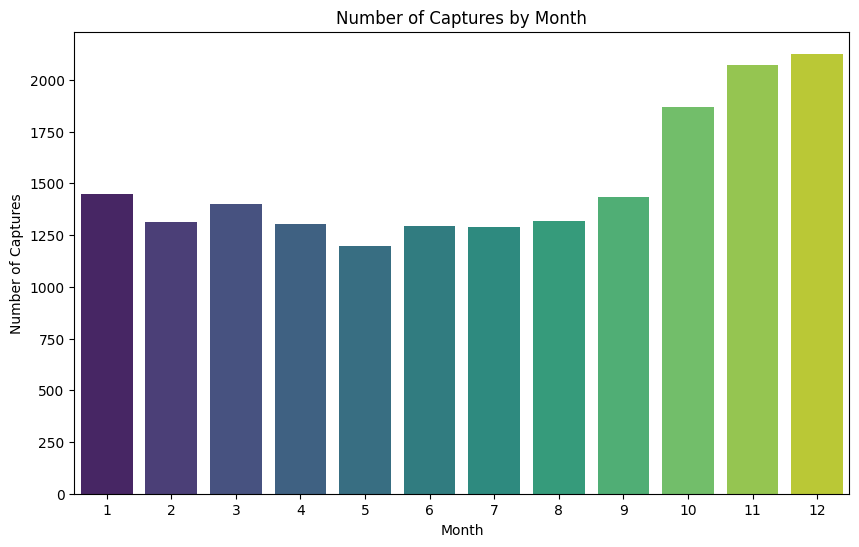

In [71]:
plt.figure(figsize=(10, 6))  # Set the figure size
sns.countplot(x='month', data=df, palette='viridis')  # Create the count plot
plt.title('Number of Captures by Month')  # Set the title of the plot
plt.xlabel('Month')  # Set the label for the x-axis
plt.ylabel('Number of Captures')  # Set the label for the y-axis
plt.show() 

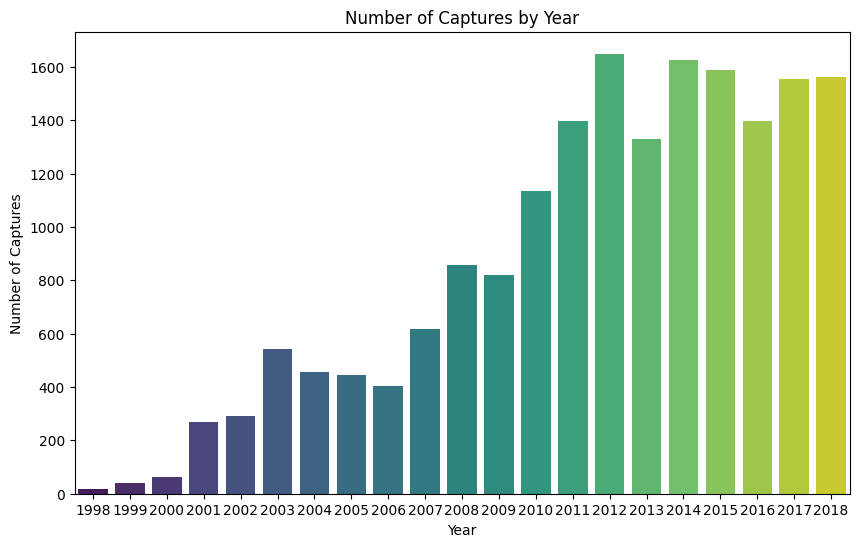

In [72]:
plt.figure(figsize=(10, 6))  # Set the figure size
sns.countplot(x='year', data=df, palette='viridis')  # Create the count plot
plt.title('Number of Captures by Year')  # Set the title of the plot
plt.xlabel('Year')  # Set the label for the x-axis
plt.ylabel('Number of Captures')  # Set the label for the y-axis
plt.show() 

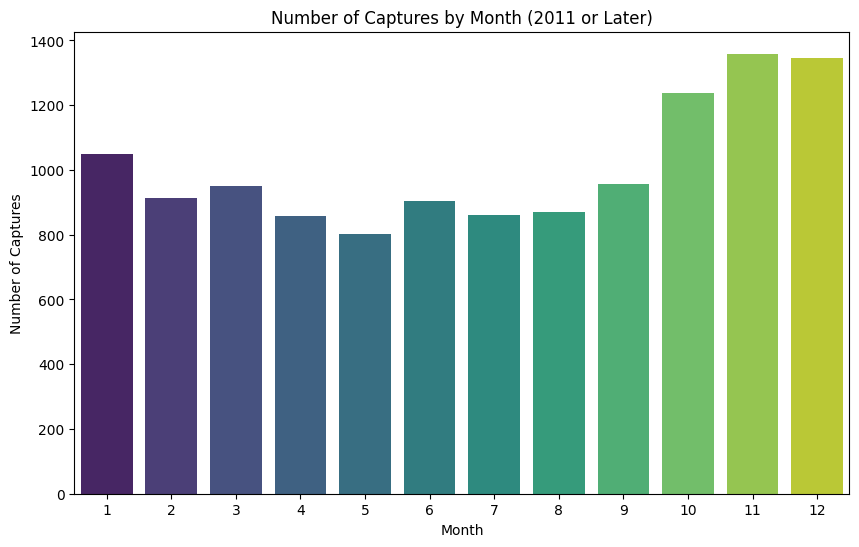

In [73]:
# Filter the DataFrame to include only captures from 2011 or later
df_filtered = df[df['year'] >= 2011]

# Create the count plot
plt.figure(figsize=(10, 6))  # Set the figure size
sns.countplot(x='month', data=df_filtered, palette='viridis')  # Create the count plot
plt.title('Number of Captures by Month (2011 or Later)')  # Set the title of the plot
plt.xlabel('Month')  # Set the label for the x-axis
plt.ylabel('Number of Captures')  # Set the label for the y-axis
plt.show()

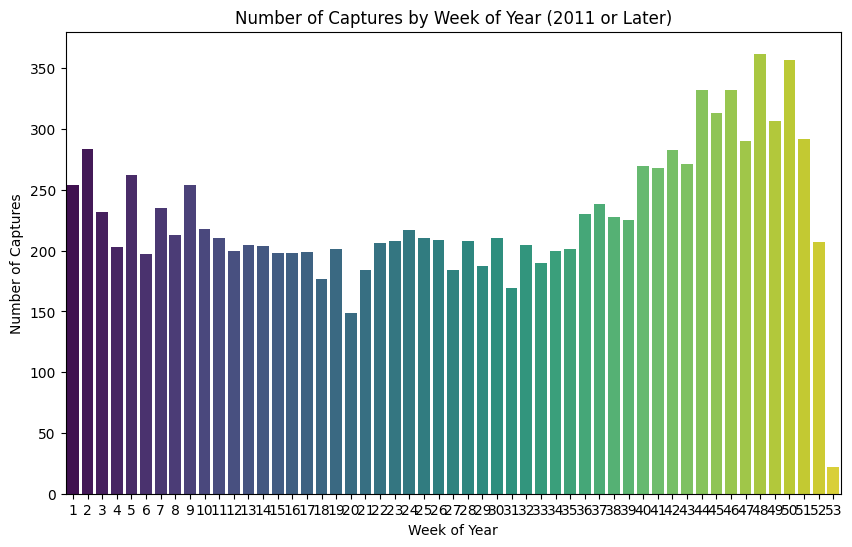

In [74]:
# Filter the DataFrame to include only captures from 2011 or later
df_filtered = df[df['year'] >= 2011]

# Create the count plot
plt.figure(figsize=(10, 6))  # Set the figure size
sns.countplot(x='week_of_year', data=df_filtered, palette='viridis')  # Create the count plot
plt.title('Number of Captures by Week of Year (2011 or Later)')  # Set the title of the plot
plt.xlabel('Week of Year')  # Set the label for the x-axis
plt.ylabel('Number of Captures')  # Set the label for the y-axis
plt.show()

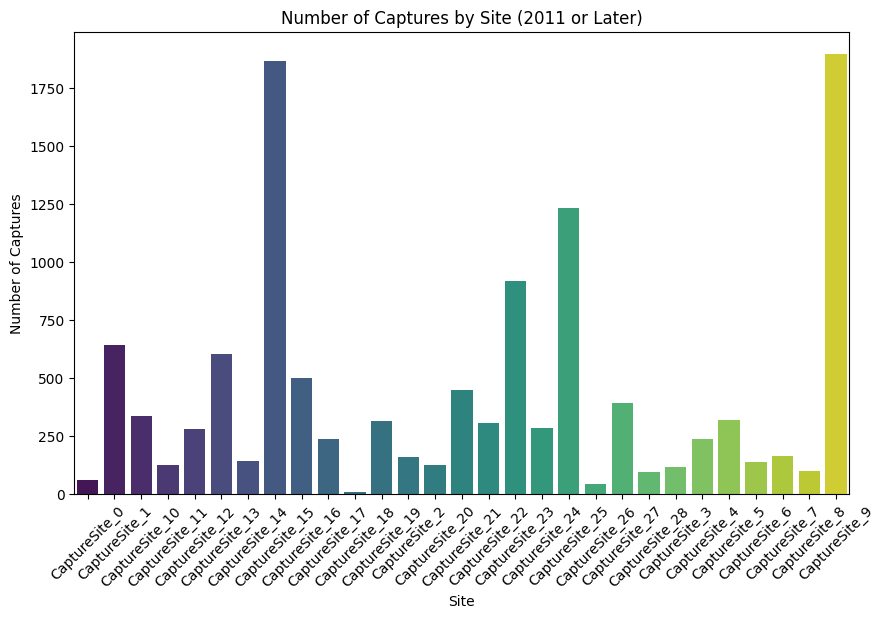

In [75]:
# Filter the DataFrame to include only captures from 2011 or later
df_filtered = df[df['year'] >= 2011]

# Create the count plot
plt.figure(figsize=(10, 6))  # Set the figure size
sns.countplot(x='CaptureSite', data=df_filtered, palette='viridis')  # Create the count plot
plt.title('Number of Captures by Site (2011 or Later)')  # Set the title of the plot
plt.xlabel('Site')  # Set the label for the x-axis
plt.ylabel('Number of Captures')  # Set the label for the y-axis
# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)
plt.show()

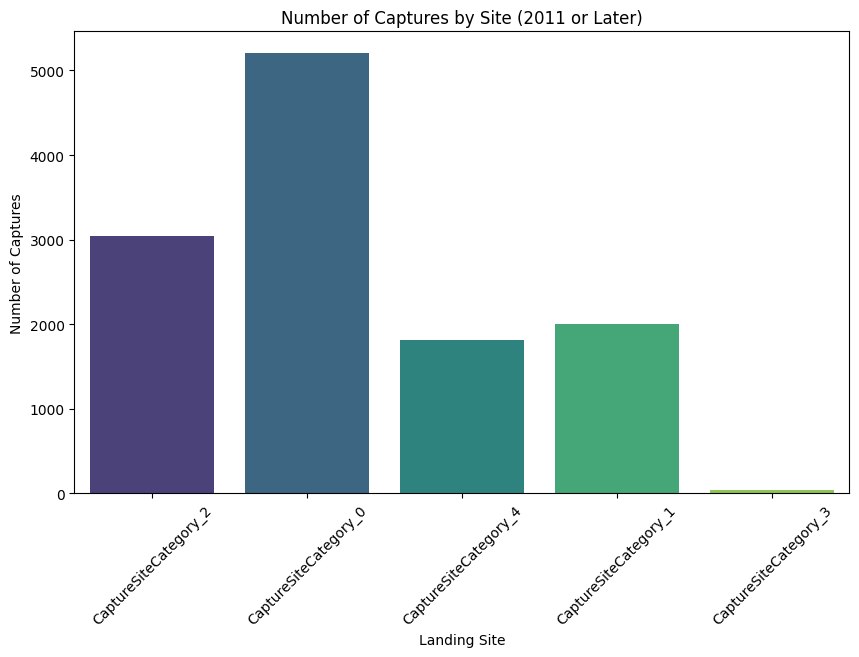

In [76]:
# Filter the DataFrame to include only captures from 2011 or later
df_filtered = df[df['year'] >= 2011]

# Create the count plot
plt.figure(figsize=(10, 6))  # Set the figure size
sns.countplot(x='LandingSite', data=df_filtered, palette='viridis')  # Create the count plot
plt.title('Number of Captures by Site (2011 or Later)')  # Set the title of the plot
plt.xlabel('Landing Site')  # Set the label for the x-axis
plt.ylabel('Number of Captures')  # Set the label for the y-axis
# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)
plt.show()

<Figure size 1000x600 with 0 Axes>

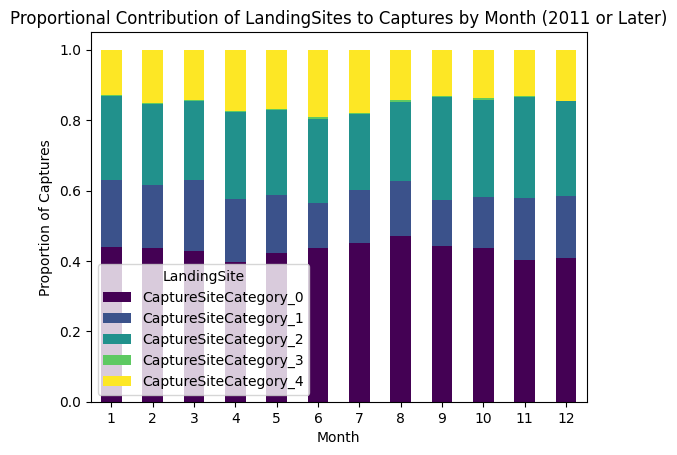

In [77]:
# Filter the DataFrame to include only captures from 2011 or later
df_filtered = df[df['year'] >= 2011]

# Pivot the DataFrame to aggregate captures by month and LandingSite
pivot_df = df_filtered.pivot_table(index='month', columns='LandingSite', aggfunc='size', fill_value=0)

# Normalize the values to get proportions
normalized_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)

# Create the stacked bar plot
plt.figure(figsize=(10, 6))  # Set the figure size
normalized_df.plot(kind='bar', stacked=True, cmap='viridis')  # Create the stacked bar plot
plt.title('Proportional Contribution of LandingSites to Captures by Month (2011 or Later)')  # Set the title of the plot
plt.xlabel('Month')  # Set the label for the x-axis
plt.ylabel('Proportion of Captures')  # Set the label for the y-axis
plt.legend(title='LandingSite')  # Add legend with LandingSite labels
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()  # Show the plot


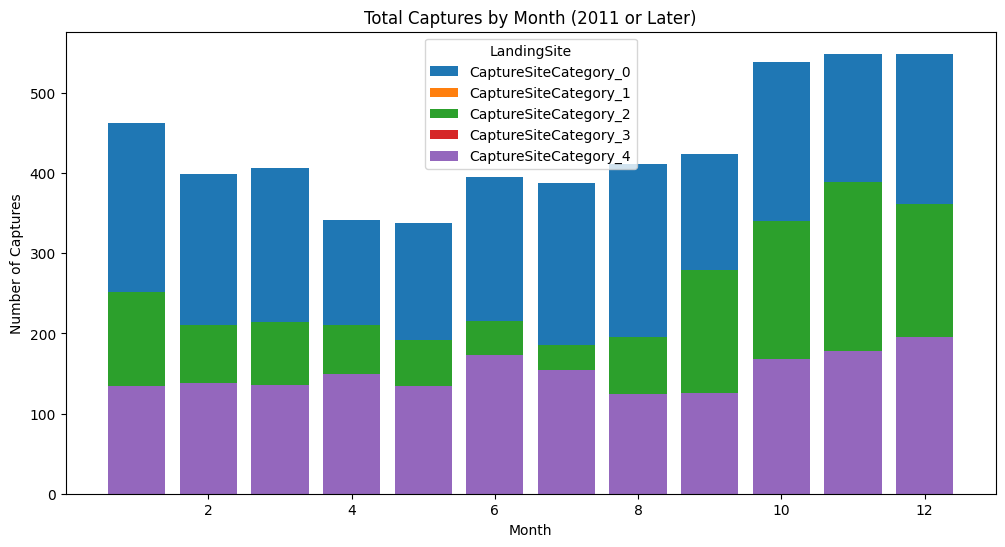

In [78]:

# Filter the DataFrame to include only captures from 2011 or later
df_filtered = df[df['year'] >= 2011]

# Pivot the DataFrame to aggregate captures by month and LandingSite
pivot_df = df_filtered.pivot_table(index='month', columns='LandingSite', aggfunc='size', fill_value=0)

# Calculate the total captures by month
total_captures_by_month = pivot_df.sum(axis=1)

# Create the stacked bar plot
plt.figure(figsize=(12, 6))  # Set the figure size
for landing_site in pivot_df.columns:
    plt.bar(pivot_df.index, pivot_df[landing_site], label=landing_site)

plt.title('Total Captures by Month (2011 or Later)')  # Set the title of the plot
plt.xlabel('Month')  # Set the label for the x-axis
plt.ylabel('Number of Captures')  # Set the label for the y-axis
plt.legend(title='LandingSite')  # Add legend with LandingSite labels
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()  # Show the plot



<Figure size 1200x600 with 0 Axes>

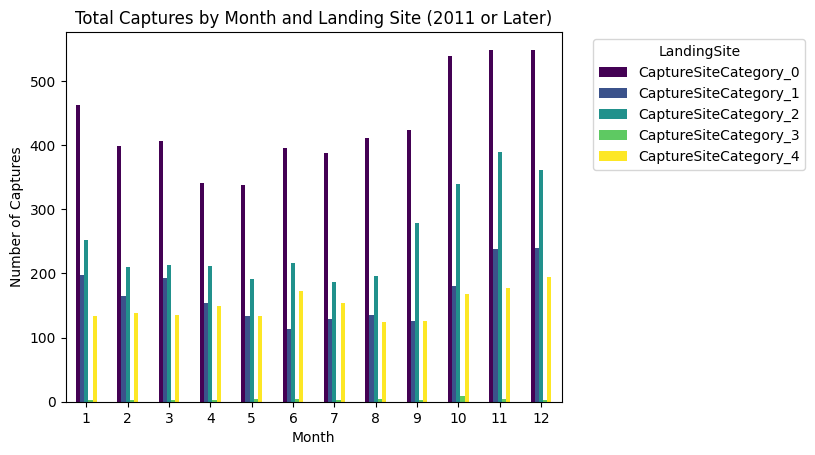

In [79]:
# Filter the DataFrame to include only captures from 2011 or later
df_filtered = df[df['year'] >= 2011]

# Pivot the DataFrame to aggregate captures by month and LandingSite
pivot_df = df_filtered.pivot_table(index='month', columns='LandingSite', aggfunc='size', fill_value=0)

# Create the grouped bar plot
plt.figure(figsize=(12, 6))  # Set the figure size
pivot_df.plot(kind='bar', stacked=False, cmap='viridis')  # Create the grouped bar plot
plt.title('Total Captures by Month and Landing Site (2011 or Later)')  # Set the title of the plot
plt.xlabel('Month')  # Set the label for the x-axis
plt.ylabel('Number of Captures')  # Set the label for the y-axis
plt.legend(title='LandingSite', bbox_to_anchor=(1.05, 1), loc='upper left')  # Add legend with LandingSite labels
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show() 

<Figure size 1200x600 with 0 Axes>

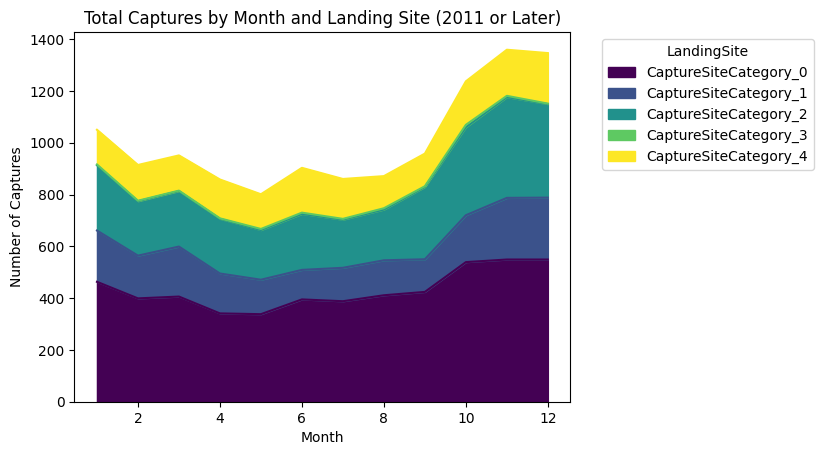

In [80]:
# Pivot the DataFrame to aggregate captures by month and LandingSite
pivot_df = df_filtered.pivot_table(index='month', columns='LandingSite', aggfunc='size', fill_value=0)

# Create the stacked area plot
plt.figure(figsize=(12, 6))  # Set the figure size
pivot_df.plot(kind='area', stacked=True, cmap='viridis')  # Create the stacked area plot
plt.title('Total Captures by Month and Landing Site (2011 or Later)')  # Set the title of the plot
plt.xlabel('Month')  # Set the label for the x-axis
plt.ylabel('Number of Captures')  # Set the label for the y-axis
plt.legend(title='LandingSite', bbox_to_anchor=(1.05, 1), loc='upper left')  # Add legend with LandingSite labels
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()

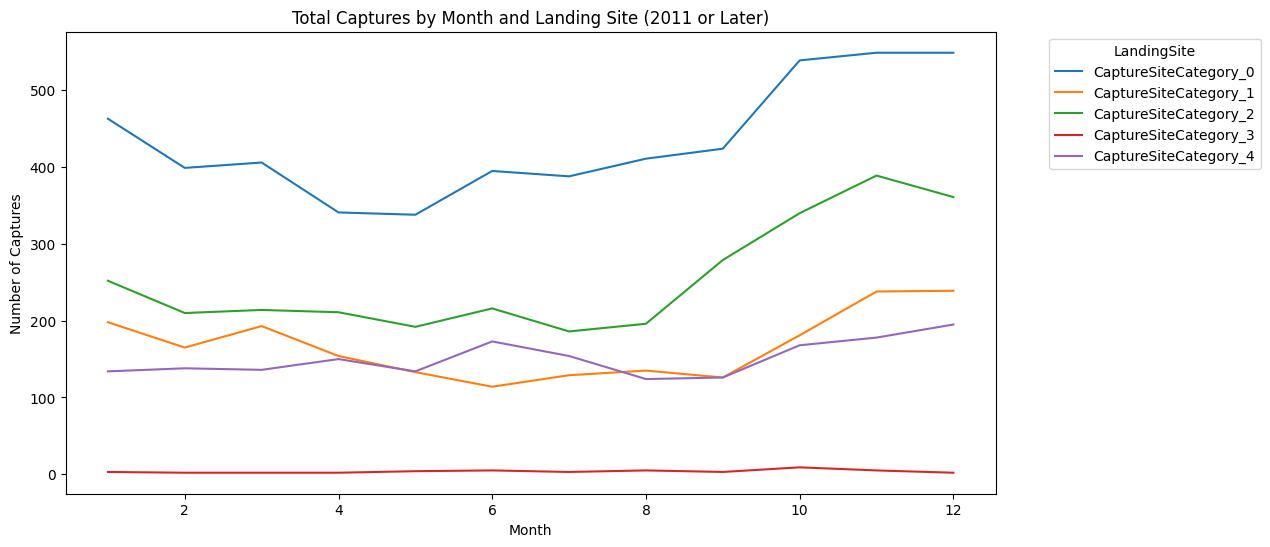

In [81]:
plt.figure(figsize=(12, 6))  # Set the figure size
for landing_site in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[landing_site], label=landing_site)
plt.title('Total Captures by Month and Landing Site (2011 or Later)')  # Set the title of the plot
plt.xlabel('Month')  # Set the label for the x-axis
plt.ylabel('Number of Captures')  # Set the label for the y-axis
plt.legend(title='LandingSite', bbox_to_anchor=(1.05, 1), loc='upper left')  # Add legend with LandingSite labels
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()

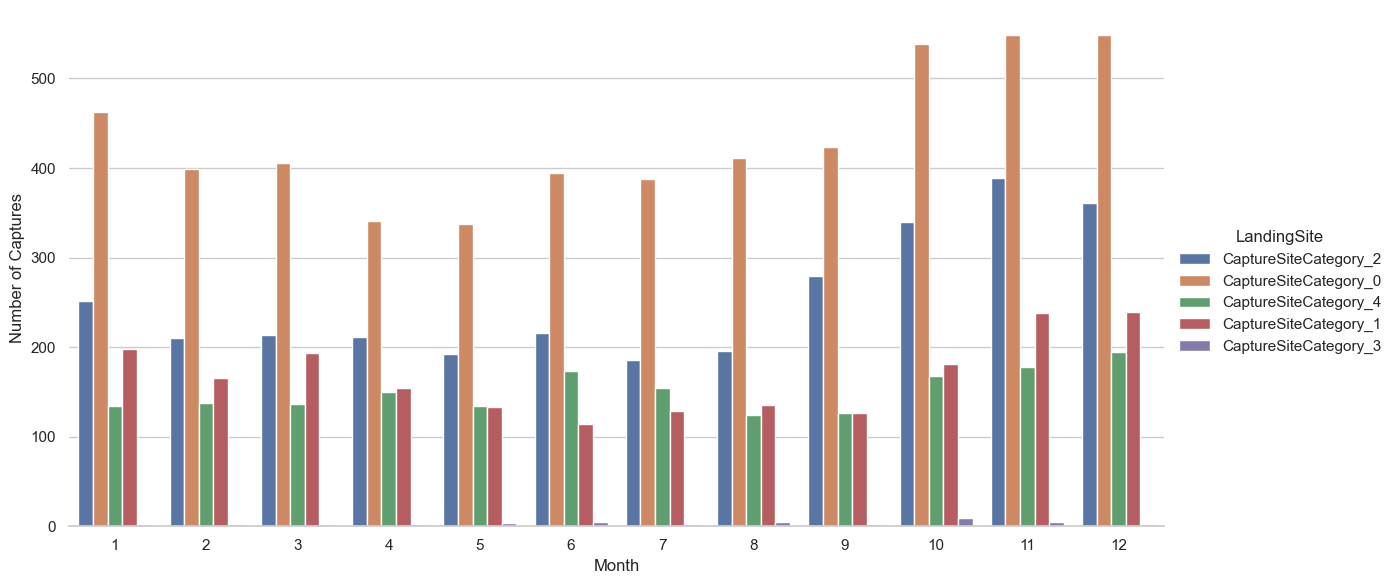

In [82]:

sns.set(style='whitegrid')
g = sns.catplot(x='month', hue='LandingSite', data=df_filtered, kind='count', height=6, aspect=2)
g.despine(left=True)
g.set_axis_labels('Month', 'Number of Captures')
g.set_titles('Total Captures by Month and Landing Site (2011 or Later)')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()

In [83]:
# Set the figure size
plt.figure(figsize=(15, 8))

# Define a list of colors for each LandingSite
landing_site_colors = {
    'CaptureSiteCategory_0': 'tab:blue',
    'CaptureSiteCategory_1': 'tab:orange',
    'CaptureSiteCategory_2': 'tab:green',
    'CaptureSiteCategory_3': 'tab:red',
    'CaptureSiteCategory_4': 'tab:purple'
}

# Iterate over each month
for month in captures_by_month_site['month'].unique():
    # Filter the data for the current month
    month_data = captures_by_month_site[captures_by_month_site['month'] == month]
    
    # Plot the pie chart
    plt.subplot(3, 4, month)
    plt.pie(month_data['Number of Captures'], labels=None, autopct='%1.1f%%', startangle=140, colors=[landing_site_colors[site] for site in month_data['LandingSite']])
    plt.title(f'Distribution of Captures for Month {month}')

# Create legend
handles = [plt.Rectangle((0,0),1,1, color=color) for color in landing_site_colors.values()]
plt.legend(handles, landing_site_colors.keys(), loc='upper right')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

NameError: name 'captures_by_month_site' is not defined

<Figure size 1500x800 with 0 Axes>

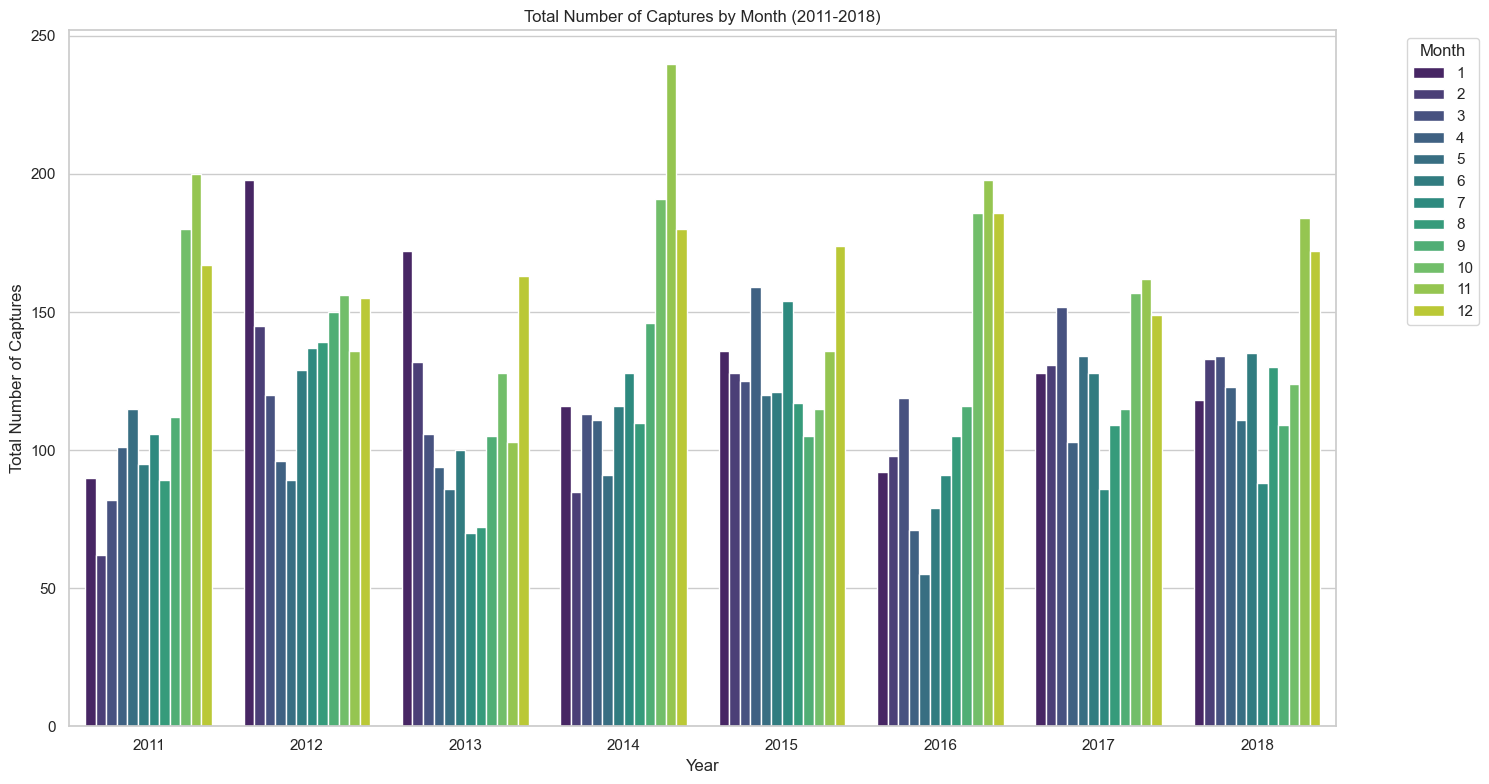

In [ ]:
# Filter the DataFrame to include captures from 2011 to 2018
df_filtered_years = df[(df['year'] >= 2011) & (df['year'] <= 2018)]

# Group the data by year and month, and calculate the total captures
captures_by_year_month = df_filtered_years.groupby(['year', 'month']).size().reset_index(name='Number of Captures')

# Set the figure size
plt.figure(figsize=(15, 8))

# Create the bar plot
sns.barplot(data=captures_by_year_month, x='year', y='Number of Captures', hue='month', palette='viridis')

# Add title and labels
plt.title('Total Number of Captures by Month (2011-2018)')
plt.xlabel('Year')
plt.ylabel('Total Number of Captures')
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

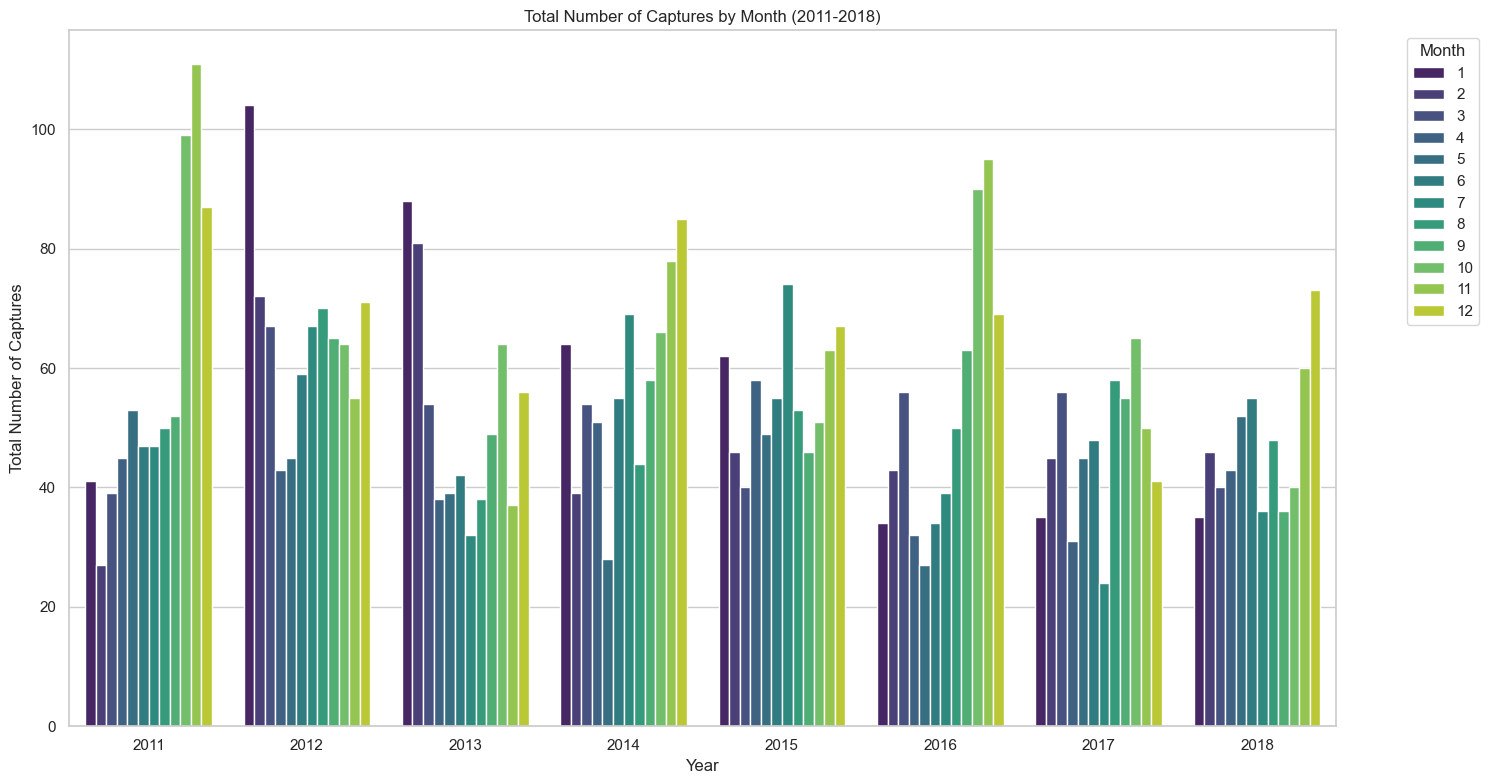

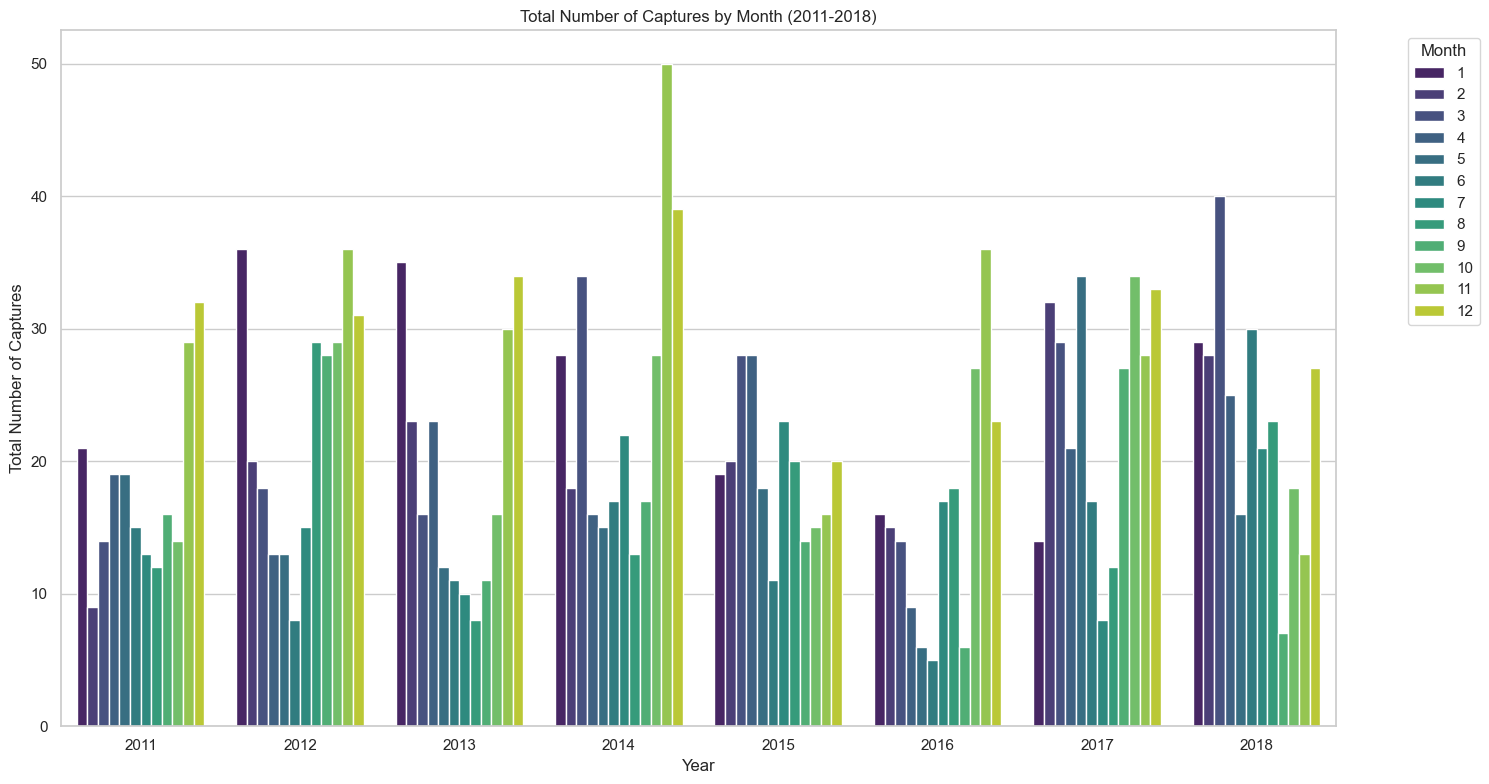

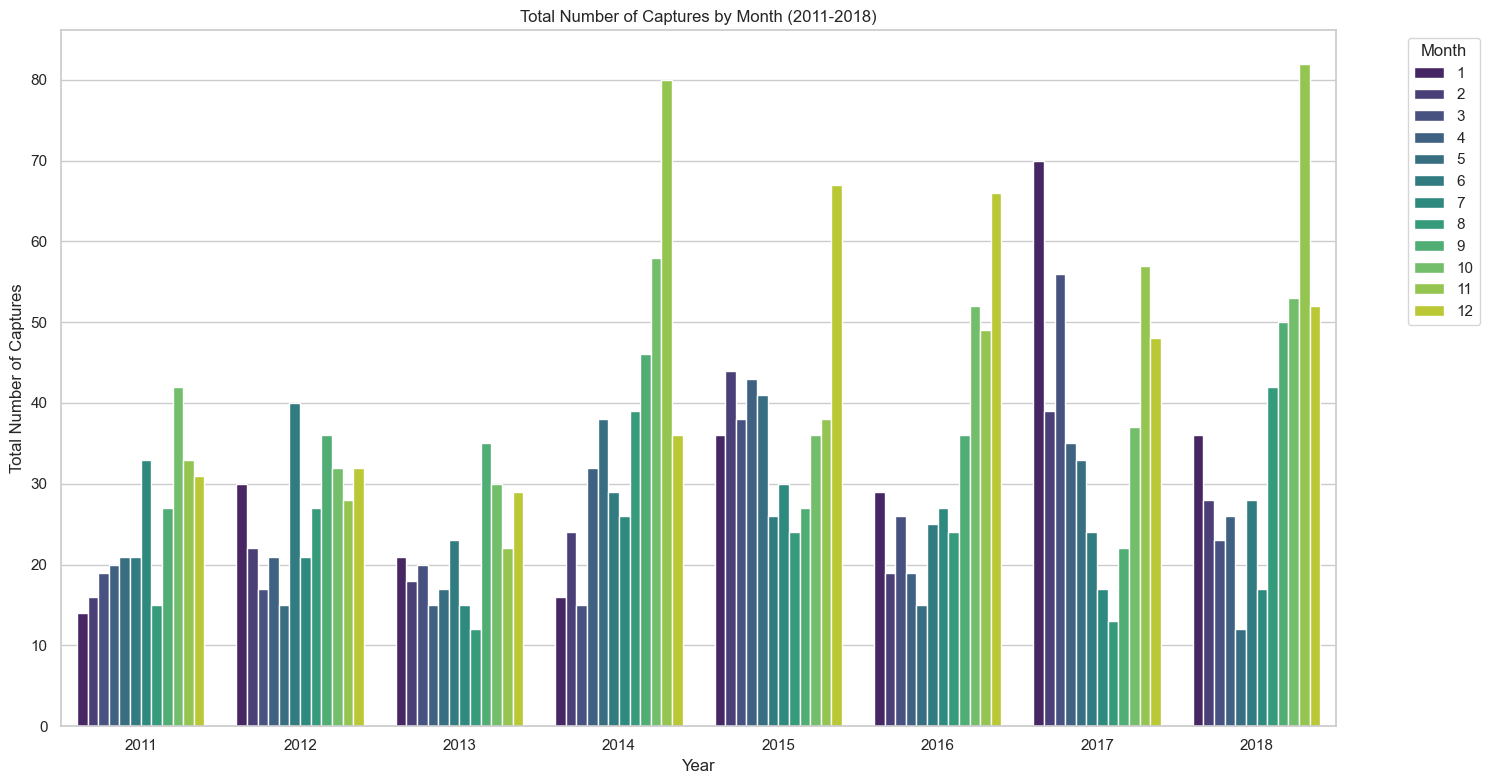

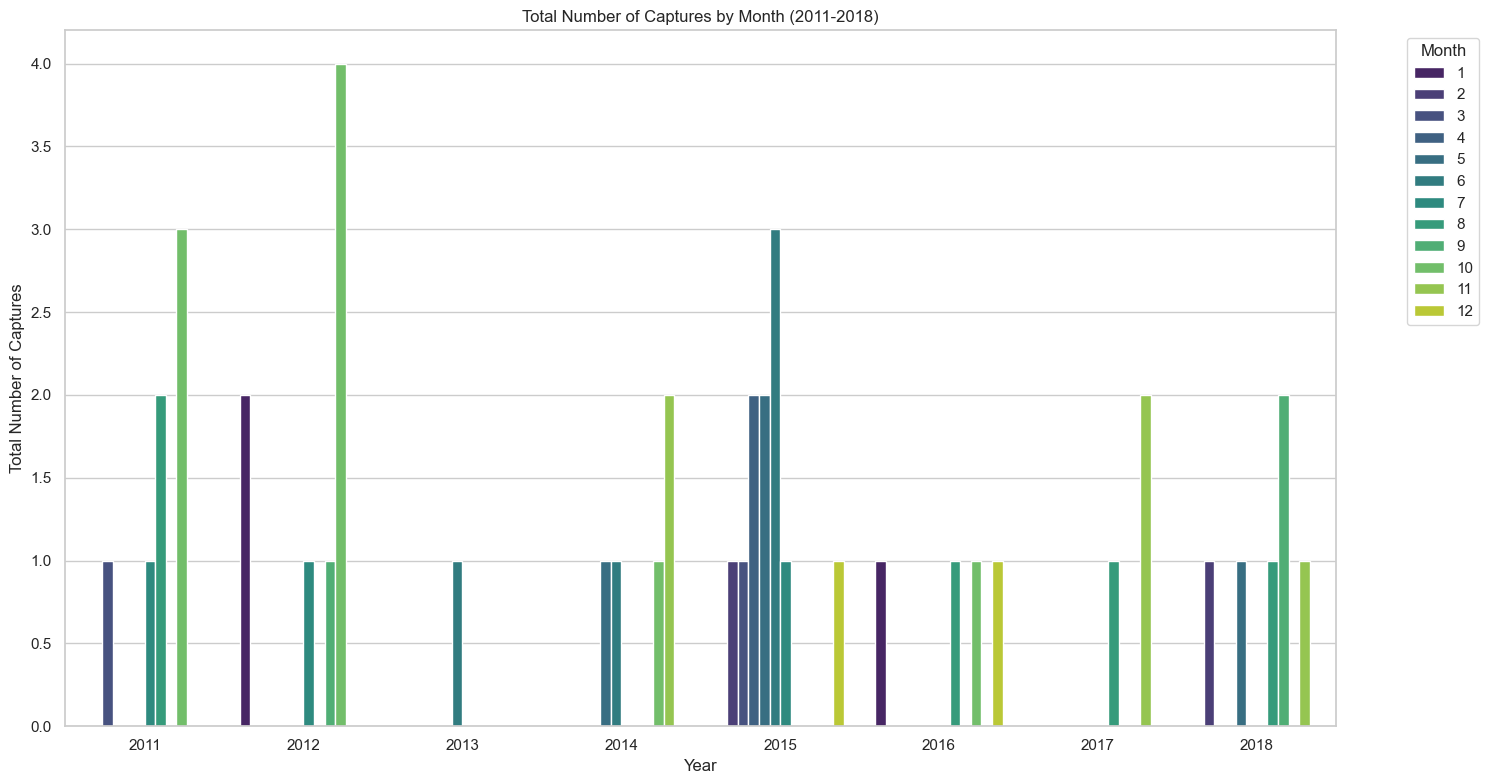

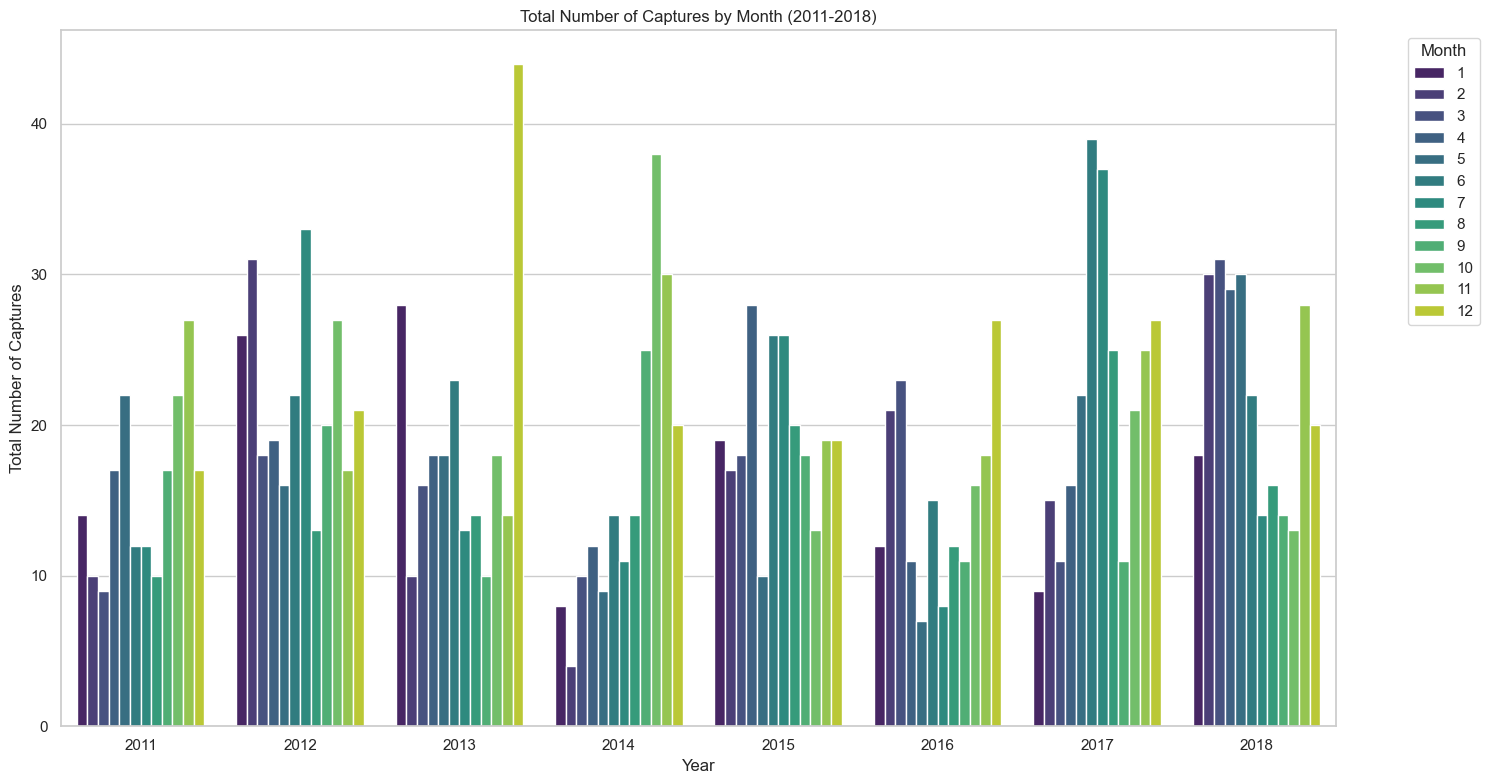

In [140]:
# Filter the DataFrame to include captures from 2011 to 2018
df_filtered_years = df[(df['year'] >= 2011) & (df['year'] <= 2018)]
grouped = df_filtered_years.groupby('LandingSite')

# Plotting
for name, group in grouped:

    # Group the data by year and month, and calculate the total captures
    captures_by_year_month = group.groupby(['year', 'month']).size().reset_index(name='Number of Captures')

    # Set the figure size
    plt.figure(figsize=(15, 8))

    # Create the bar plot
    sns.barplot(data=captures_by_year_month, x='year', y='Number of Captures', hue='month', palette='viridis')

    # Add title and labels
    plt.title('Total Number of Captures by Month (2011-2018)')
    plt.xlabel('Year')
    plt.ylabel('Total Number of Captures')
    plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=0)
    plt.tight_layout()

    # Show the plot
    plt.show()

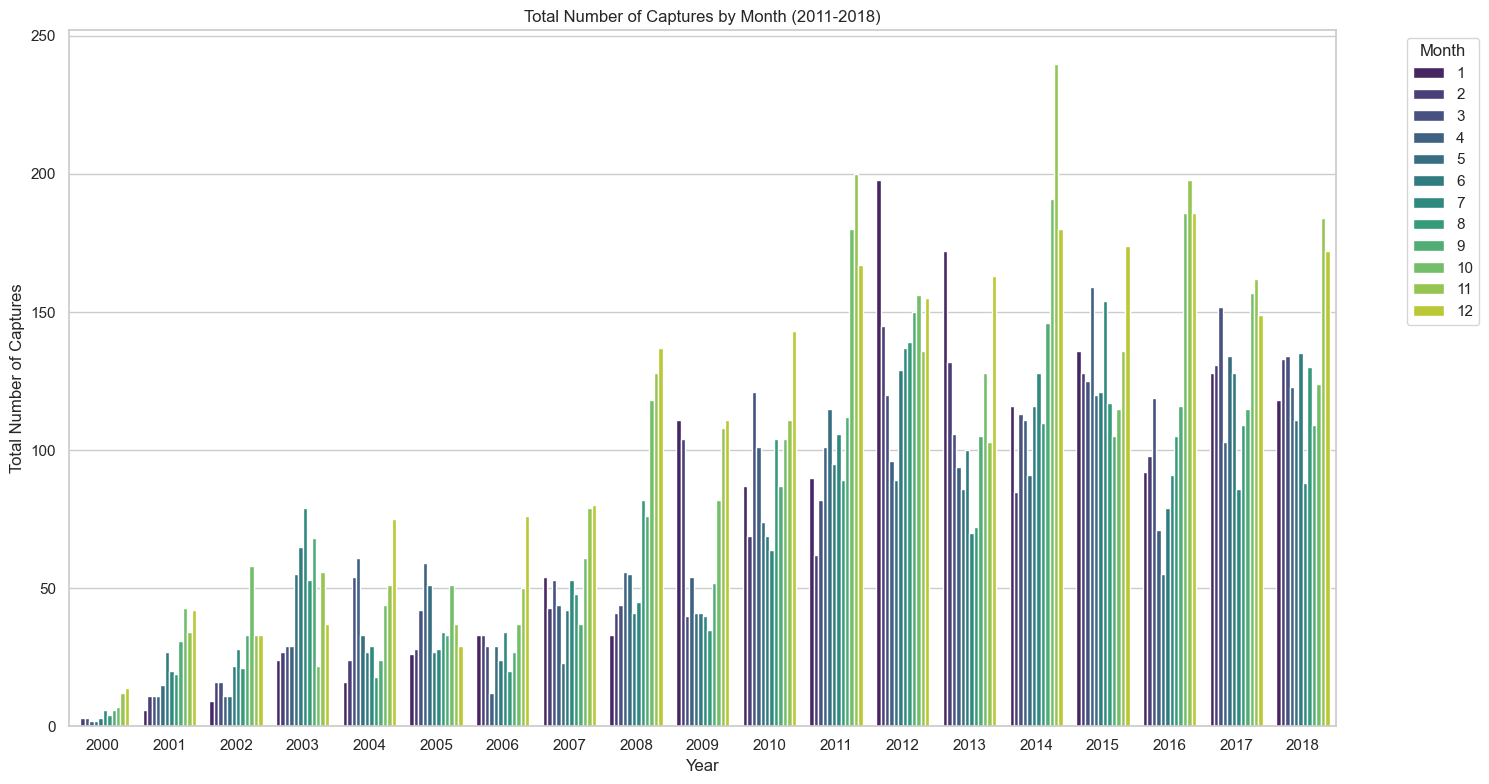

In [ ]:
# Filter the DataFrame to include captures from 2011 to 2018
df_filtered_years = df[(df['year'] >= 2000) & (df['year'] <= 2018)]

# Group the data by year and month, and calculate the total captures
captures_by_year_month = df_filtered_years.groupby(['year', 'month']).size().reset_index(name='Number of Captures')

# Set the figure size
plt.figure(figsize=(15, 8))

# Create the bar plot
sns.barplot(data=captures_by_year_month, x='year', y='Number of Captures', hue='month', palette='viridis')

# Add title and labels
plt.title('Total Number of Captures by Month (2011-2018)')
plt.xlabel('Year')
plt.ylabel('Total Number of Captures')
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

Text(0, 0.5, 'Number of NaN Status')

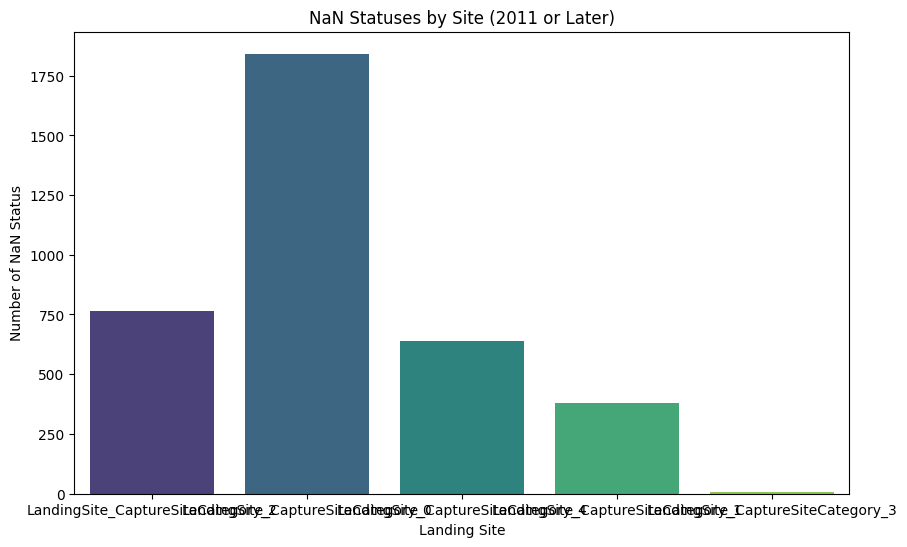

In [19]:


# Create the count plot
plt.figure(figsize=(10, 6))  # Set the figure size
sns.countplot(x='LandingSite', data=status_nan, palette='viridis')  # Create the count plot
plt.title('NaN Statuses by Site (2011 or Later)')  # Set the title of the plot
plt.xlabel('Landing Site')  # Set the label for the x-axis
plt.ylabel('Number of NaN Status')  # Set the label for the y-axis


## it is fair to say that during the warmer/late spring early summer months (October to January) more turtles are caught during this breeding season

### There also seems to be a fairly consistent distribution among the landing sites for where employees ought to be ready to meet fishers

## Baseline Model

Here, the baseline model should simply be the prediction for each week at each LandingSite or CaptureSite (that part still not totally clear), based on averages of each week and site over the last however-many years we decide.

It seems pretty clear to me that 2011 was when the program really started to gain some steam, in years prior, it seems like cooperation with the fishers in the area was still being fostered, and not fully developed yet. In the late 90s/early 00s, there aren't many reported captures. 

Split the data -- (not sure how exactly yet to handle that, we need to chat about the 2019 data in the "sample sub")

Calculate Average Captures: Calculate the average number of turtle captures for each combination of site and year/week of year. This involves grouping the data by site and year/week and calculating the mean number of captures for each week by year and group.

Baseline Prediction: For a given site and date combination in the test data, predict the average number of captures calculated in step 2 as the baseline prediction.

Evaluation: Evaluate the performance of the baseline model using appropriate metrics such as Mean Absolute Error (MAE) or Root Mean Squared Error (RMSE) by comparing the baseline predictions to the actual number of turtle captures in the test data.

Interpretation: Analyze the performance of the baseline model to establish a benchmark for comparison with more advanced predictive models. This will help assess whether more sophisticated techniques offer significant improvements over the baseline, or if this is the best that can be done with the data on hand.

## Morning Recap

#### Consensus

1. Splitting the data -- From 2011 onward, 2018 will be our test data
2. ignore the submission sample
3. using LandingSite instead of CaptureSite (capture site category)
4. Week 53, leave it as it is
5. January dates are fine in 53


#### To-Do
1. Baseline Model
2. Test/Evaluate Baseline Model 
3. Machine Learning Models to compare ***
4. Final Product brainstorming for presentation ***

*** means it is easily split between three people

In [94]:
df_train = df[(df['year'] <= 2017) & (df['year'] >= 2011)]
df_train

,Date_TimeCaught,CaptureSite,ForagingGround,Fisher,LandingSite,Weight_Kg,Status,area_sqcm,Type,year,month,week_of_year,year_woy
33,2011-06-17,CaptureSite_0,ocean,Fisher_2133,CaptureSiteCategory_2,8.500000,NaN,17.0150,Type_1,2011,6,24,201124
34,2011-06-22,CaptureSite_0,ocean,Fisher_513,CaptureSiteCategory_2,70.000000,NaN,83.2194,Type_1,2011,6,25,201125
35,2011-08-16,CaptureSite_0,ocean,Fisher_649,CaptureSiteCategory_2,8.500000,NaN,16.1850,Type_1,2011,8,33,201133
36,2011-08-28,CaptureSite_0,ocean,Fisher_296,CaptureSiteCategory_2,6.500000,Released,13.0652,Type_1,2011,8,34,201134
37,2011-10-22,CaptureSite_0,ocean,Fisher_1550,CaptureSiteCategory_2,55.708539,Released,57.7430,Type_1,2011,10,42,201142
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17784,2017-12-28,CaptureSite_9,ocean,Fisher_1551,CaptureSiteCategory_1,6.810000,Released,13.5168,Type_1,2017,12,52,201752
17785,2017-12-29,CaptureSite_9,ocean,Fisher_1343,CaptureSiteCategory_1,5.930000,Released,14.2803,Type_1,2017,12,52,201752
17786,2017-12-30,CaptureSite_9,ocean,Fisher_1551,CaptureSiteCategory_1,16.500000,Released,24.4625,Type_1,2017,12,52,201752
17787,2017-12-30,CaptureSite_9,ocean,Fisher_1472,CaptureSiteCategory_1,22.700000,Released,35.4200,Type_1,2017,12,52,201752


In [141]:
df_train2 = df[(df['year'] <= 2017) & (df['year'] >= 2014)]
df_train2

,Date_TimeCaught,CaptureSite,ForagingGround,Fisher,LandingSite,Weight_Kg,Status,area_sqcm,Type,year,month,week_of_year,year_woy
45,2014-05-28,CaptureSite_0,creek,Fisher_1841,CaptureSiteCategory_2,5.92,Released,13.246000,Type_1,2014,5,22,201422
46,2014-06-15,CaptureSite_0,ocean,Fisher_1625,CaptureSiteCategory_2,9.27,Released,18.914400,Type_1,2014,6,24,201424
47,2014-07-25,CaptureSite_0,ocean,Fisher_2100,CaptureSiteCategory_2,3.95,Released,11.486171,Type_1,2014,7,30,201430
48,2014-08-26,CaptureSite_0,ocean,Fisher_1217,CaptureSiteCategory_2,8.56,Released,16.596600,Type_1,2014,8,35,201435
49,2014-09-14,CaptureSite_0,ocean,Fisher_1964,CaptureSiteCategory_2,2.79,Released,7.823100,Type_1,2014,9,37,201437
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17784,2017-12-28,CaptureSite_9,ocean,Fisher_1551,CaptureSiteCategory_1,6.81,Released,13.516800,Type_1,2017,12,52,201752
17785,2017-12-29,CaptureSite_9,ocean,Fisher_1343,CaptureSiteCategory_1,5.93,Released,14.280300,Type_1,2017,12,52,201752
17786,2017-12-30,CaptureSite_9,ocean,Fisher_1551,CaptureSiteCategory_1,16.50,Released,24.462500,Type_1,2017,12,52,201752
17787,2017-12-30,CaptureSite_9,ocean,Fisher_1472,CaptureSiteCategory_1,22.70,Released,35.420000,Type_1,2017,12,52,201752


In [186]:
df_train3 = df_train2[(df_train2['year'] <= 2017) & (df_train2['year'] >= 2015)]
df_train3

,Date_TimeCaught,CaptureSite,ForagingGround,Fisher,LandingSite,Weight_Kg,Status,area_sqcm,Type,year,month,week_of_year,year_woy
54,2015-01-06,CaptureSite_0,ocean,Fisher_2092,CaptureSiteCategory_2,5.00,Released,11.5500,Type_1,2015,1,2,201502
55,2015-01-16,CaptureSite_0,ocean,Fisher_85,CaptureSiteCategory_2,8.20,Admitted,18.0400,Type_1,2015,1,3,201503
56,2015-03-02,CaptureSite_0,ocean,Fisher_1108,CaptureSiteCategory_2,27.20,Released,32.7484,Type_1,2015,3,10,201510
57,2015-04-20,CaptureSite_0,ocean,Fisher_1964,CaptureSiteCategory_2,11.13,Released,19.8660,Type_1,2015,4,17,201517
58,2015-04-20,CaptureSite_0,ocean,Fisher_1964,CaptureSiteCategory_2,12.53,Released,20.9216,Type_1,2015,4,17,201517
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17784,2017-12-28,CaptureSite_9,ocean,Fisher_1551,CaptureSiteCategory_1,6.81,Released,13.5168,Type_1,2017,12,52,201752
17785,2017-12-29,CaptureSite_9,ocean,Fisher_1343,CaptureSiteCategory_1,5.93,Released,14.2803,Type_1,2017,12,52,201752
17786,2017-12-30,CaptureSite_9,ocean,Fisher_1551,CaptureSiteCategory_1,16.50,Released,24.4625,Type_1,2017,12,52,201752
17787,2017-12-30,CaptureSite_9,ocean,Fisher_1472,CaptureSiteCategory_1,22.70,Released,35.4200,Type_1,2017,12,52,201752


In [170]:
#df_test = df[df['year'] == 2018]
#df_test[df_test['LandingSite'] == 'CaptureSiteCategory_3']
df_test

,Date_TimeCaught,CaptureSite,ForagingGround,Fisher,LandingSite,Weight_Kg,Status,area_sqcm,Type,year,month,week_of_year,year_woy
85,2018-01-14,CaptureSite_0,ocean,Fisher_809,CaptureSiteCategory_2,4.250000,Released,10.889100,Type_1,2018,1,2,201802
86,2018-01-17,CaptureSite_0,ocean,Fisher_809,CaptureSiteCategory_2,2.680000,Released,7.600760,Type_1,2018,1,3,201803
87,2018-02-01,CaptureSite_0,ocean,Fisher_809,CaptureSiteCategory_2,5.450000,Released,12.320930,Type_1,2018,2,5,201805
88,2018-02-19,CaptureSite_0,ocean,Fisher_809,CaptureSiteCategory_2,3.440000,Released,9.017439,Type_1,2018,2,8,201808
89,2018-06-21,CaptureSite_0,ocean,Fisher_606,CaptureSiteCategory_2,10.410000,Released,18.870561,Type_1,2018,6,25,201825
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18057,2018-12-18,CaptureSite_9,ocean,Fisher_569,CaptureSiteCategory_1,21.090000,Released,28.890641,Type_1,2018,12,51,201851
18058,2018-12-18,CaptureSite_9,ocean,Fisher_125,CaptureSiteCategory_1,9.020000,Released,16.142259,Type_1,2018,12,51,201851
18059,2018-12-24,CaptureSite_9,ocean,Fisher_1343,CaptureSiteCategory_1,20.461698,Released,29.915600,Type_1,2018,12,52,201852
18060,2018-12-24,CaptureSite_9,ocean,Fisher_1551,CaptureSiteCategory_1,15.618496,Released,25.171500,Type_1,2018,12,52,201852


In [96]:
# Group by 'LandingSite', 'year', and 'week_of_year', then count the number of turtle captures
turtle_week_train = df_train.groupby(['LandingSite', 'year', 'week_of_year', 'year_woy']).size().reset_index(name='number_turtles')

# Display the result
turtle_week_train

,LandingSite,year,week_of_year,year_woy,number_turtles
0,CaptureSiteCategory_0,2011,1,201101,21
1,CaptureSiteCategory_0,2011,2,201102,12
2,CaptureSiteCategory_0,2011,3,201103,2
3,CaptureSiteCategory_0,2011,4,201104,6
4,CaptureSiteCategory_0,2011,5,201105,5
...,...,...,...,...,...
1451,CaptureSiteCategory_4,2017,48,201748,8
1452,CaptureSiteCategory_4,2017,49,201749,5
1453,CaptureSiteCategory_4,2017,50,201750,12
1454,CaptureSiteCategory_4,2017,51,201751,1


In [142]:
# Group by 'LandingSite', 'year', and 'week_of_year', then count the number of turtle captures
turtle_week_train2 = df_train2.groupby(['LandingSite', 'year', 'week_of_year', 'year_woy']).size().reset_index(name='number_turtles')

# Display the result
turtle_week_train2

,LandingSite,year,week_of_year,year_woy,number_turtles
0,CaptureSiteCategory_0,2014,1,201401,17
1,CaptureSiteCategory_0,2014,2,201402,39
2,CaptureSiteCategory_0,2014,3,201403,3
3,CaptureSiteCategory_0,2014,4,201404,14
4,CaptureSiteCategory_0,2014,5,201405,8
...,...,...,...,...,...
834,CaptureSiteCategory_4,2017,48,201748,8
835,CaptureSiteCategory_4,2017,49,201749,5
836,CaptureSiteCategory_4,2017,50,201750,12
837,CaptureSiteCategory_4,2017,51,201751,1


In [187]:
# Group by 'LandingSite', 'year', and 'week_of_year', then count the number of turtle captures
turtle_week_train3 = df_train3.groupby(['LandingSite', 'year', 'week_of_year', 'year_woy']).size().reset_index(name='number_turtles')

# Display the result
turtle_week_train3

,LandingSite,year,week_of_year,year_woy,number_turtles
0,CaptureSiteCategory_0,2015,1,201501,9
1,CaptureSiteCategory_0,2015,2,201502,11
2,CaptureSiteCategory_0,2015,3,201503,25
3,CaptureSiteCategory_0,2015,4,201504,1
4,CaptureSiteCategory_0,2015,5,201505,19
...,...,...,...,...,...
625,CaptureSiteCategory_4,2017,48,201748,8
626,CaptureSiteCategory_4,2017,49,201749,5
627,CaptureSiteCategory_4,2017,50,201750,12
628,CaptureSiteCategory_4,2017,51,201751,1


In [171]:
# Group by 'LandingSite', 'year', and 'week_of_year', then count the number of turtle captures
turtle_week_test = df_test.groupby(['LandingSite', 'year', 'week_of_year', 'year_woy']).size().reset_index(name='number_turtles')

# Display the result
turtle_week_test[turtle_week_test['LandingSite'] == 'CaptureSiteCategory_3']

,LandingSite,year,week_of_year,year_woy,number_turtles
154,CaptureSiteCategory_3,2018,5,201805,1
155,CaptureSiteCategory_3,2018,18,201818,1
156,CaptureSiteCategory_3,2018,33,201833,1
157,CaptureSiteCategory_3,2018,37,201837,1
158,CaptureSiteCategory_3,2018,39,201839,1
159,CaptureSiteCategory_3,2018,45,201845,1


### getting the means of each week by year by landing site

In [106]:
train_mean = turtle_week_train.groupby(['LandingSite', 'week_of_year'])['number_turtles'].mean().reset_index(name='mean_turtles')
train_mean['mean_turtles'] = train_mean['mean_turtles'].round()
train_mean

,LandingSite,week_of_year,mean_turtles
0,CaptureSiteCategory_0,1,15.0
1,CaptureSiteCategory_0,2,18.0
2,CaptureSiteCategory_0,3,12.0
3,CaptureSiteCategory_0,4,11.0
4,CaptureSiteCategory_0,5,18.0
...,...,...,...
236,CaptureSiteCategory_4,49,6.0
237,CaptureSiteCategory_4,50,7.0
238,CaptureSiteCategory_4,51,6.0
239,CaptureSiteCategory_4,52,4.0


In [143]:
train_mean2 = turtle_week_train2.groupby(['LandingSite', 'week_of_year'])['number_turtles'].mean().reset_index(name='mean_turtles')
train_mean2['mean_turtles'] = train_mean2['mean_turtles'].round()
train_mean2

,LandingSite,week_of_year,mean_turtles
0,CaptureSiteCategory_0,1,14.0
1,CaptureSiteCategory_0,2,16.0
2,CaptureSiteCategory_0,3,11.0
3,CaptureSiteCategory_0,4,6.0
4,CaptureSiteCategory_0,5,15.0
...,...,...,...
225,CaptureSiteCategory_4,49,5.0
226,CaptureSiteCategory_4,50,7.0
227,CaptureSiteCategory_4,51,3.0
228,CaptureSiteCategory_4,52,4.0


In [188]:
train_mean3 = turtle_week_train3.groupby(['LandingSite', 'week_of_year'])['number_turtles'].mean().reset_index(name='mean_turtles')
train_mean3['mean_turtles'] = train_mean3['mean_turtles'].round()
train_mean3

,LandingSite,week_of_year,mean_turtles
0,CaptureSiteCategory_0,1,12.0
1,CaptureSiteCategory_0,2,8.0
2,CaptureSiteCategory_0,3,14.0
3,CaptureSiteCategory_0,4,3.0
4,CaptureSiteCategory_0,5,18.0
...,...,...,...
222,CaptureSiteCategory_4,49,6.0
223,CaptureSiteCategory_4,50,9.0
224,CaptureSiteCategory_4,51,2.0
225,CaptureSiteCategory_4,52,4.0


In [172]:
# train_mean['actual_number'] = turtle_week_test['number_turtles']
# train_mean

,LandingSite,week_of_year,mean_turtles,actual_number
0,CaptureSiteCategory_0,1,15.0,9.0
1,CaptureSiteCategory_0,2,18.0,13.0
2,CaptureSiteCategory_0,3,12.0,5.0
3,CaptureSiteCategory_0,4,11.0,7.0
4,CaptureSiteCategory_0,5,18.0,9.0
...,...,...,...,...
236,CaptureSiteCategory_4,49,6.0,NaN
237,CaptureSiteCategory_4,50,7.0,NaN
238,CaptureSiteCategory_4,51,6.0,NaN
239,CaptureSiteCategory_4,52,4.0,NaN


In [191]:
train_mean3

,LandingSite,week_of_year,mean_turtles
0,CaptureSiteCategory_0,1,12.0
1,CaptureSiteCategory_0,2,8.0
2,CaptureSiteCategory_0,3,14.0
3,CaptureSiteCategory_0,4,3.0
4,CaptureSiteCategory_0,5,18.0
...,...,...,...
222,CaptureSiteCategory_4,49,6.0
223,CaptureSiteCategory_4,50,9.0
224,CaptureSiteCategory_4,51,2.0
225,CaptureSiteCategory_4,52,4.0


In [193]:
all_weeks = pd.DataFrame({'week_of_year': range(1, 54)})
all_sites = pd.DataFrame({'LandingSite': turtle_week_train['LandingSite'].unique()})

# Cartesian product to get all possible combinations of 'week_of_year' and 'LandingSite'
all_combinations = all_weeks.assign(key=1).merge(all_sites.assign(key=1), on='key').drop(columns='key')

# Merge with the aggregated DataFrame to fill in missing values with 0
train_mean_all = all_combinations.merge(train_mean, how='left', on=['LandingSite', 'week_of_year']).fillna(0)
train_mean_all = train_mean_all.merge(train_mean2, how='left', on=['LandingSite', 'week_of_year']).fillna(0)
train_mean_all = train_mean_all.merge(train_mean3, how='left', on=['LandingSite', 'week_of_year']).fillna(0)
train_mean_all = train_mean_all.merge(turtle_week_test, how='left', on=['LandingSite', 'week_of_year']).fillna(0)

train_mean_all['mean_turtles_2011'] = train_mean_all['mean_turtles_x'].round().astype(int)
train_mean_all['mean_turtles_2014'] = train_mean_all['mean_turtles_y'].round().astype(int)
train_mean_all['mean_turtles_2015'] = train_mean_all['mean_turtles'].round().astype(int)
train_mean_all['actual_number'] = train_mean_all['number_turtles'].round().astype(int)

train_mean_all.drop('mean_turtles_y', axis=1, inplace=True)
train_mean_all.drop('mean_turtles_x', axis=1, inplace=True)
train_mean_all.drop('mean_turtles', axis=1, inplace=True)
train_mean_all.drop('year', axis=1, inplace=True)
train_mean_all.drop('year_woy', axis=1, inplace=True)
train_mean_all.drop('number_turtles', axis=1, inplace=True)

train_mean_all


,week_of_year,LandingSite,actual_number,mean_turtles_2011,mean_turtles_2014,mean_turtles_2015
0,1,CaptureSiteCategory_0,9,15,14,12
1,1,CaptureSiteCategory_1,3,5,4,4
2,1,CaptureSiteCategory_2,12,9,10,11
3,1,CaptureSiteCategory_3,0,1,0,0
4,1,CaptureSiteCategory_4,3,4,2,1
...,...,...,...,...,...,...
260,53,CaptureSiteCategory_0,0,3,3,3
261,53,CaptureSiteCategory_1,0,2,2,2
262,53,CaptureSiteCategory_2,0,4,4,4
263,53,CaptureSiteCategory_3,0,0,0,0


In [194]:
train_mean_all['diff_2011'] = train_mean_all['actual_number'] - train_mean_all['mean_turtles_2011']
train_mean_all['diff_2014'] = train_mean_all['actual_number'] - train_mean_all['mean_turtles_2014']
train_mean_all['diff_2015'] = train_mean_all['actual_number'] - train_mean_all['mean_turtles_2015']
df = train_mean_all
df

,week_of_year,LandingSite,actual_number,mean_turtles_2011,mean_turtles_2014,mean_turtles_2015,diff_2011,diff_2014,diff_2015
0,1,CaptureSiteCategory_0,9,15,14,12,-6,-5,-3
1,1,CaptureSiteCategory_1,3,5,4,4,-2,-1,-1
2,1,CaptureSiteCategory_2,12,9,10,11,3,2,1
3,1,CaptureSiteCategory_3,0,1,0,0,-1,0,0
4,1,CaptureSiteCategory_4,3,4,2,1,-1,1,2
...,...,...,...,...,...,...,...,...,...
260,53,CaptureSiteCategory_0,0,3,3,3,-3,-3,-3
261,53,CaptureSiteCategory_1,0,2,2,2,-2,-2,-2
262,53,CaptureSiteCategory_2,0,4,4,4,-4,-4,-4
263,53,CaptureSiteCategory_3,0,0,0,0,0,0,0


# WE ARE WORKING WITH 'DF' FROM NOW ON

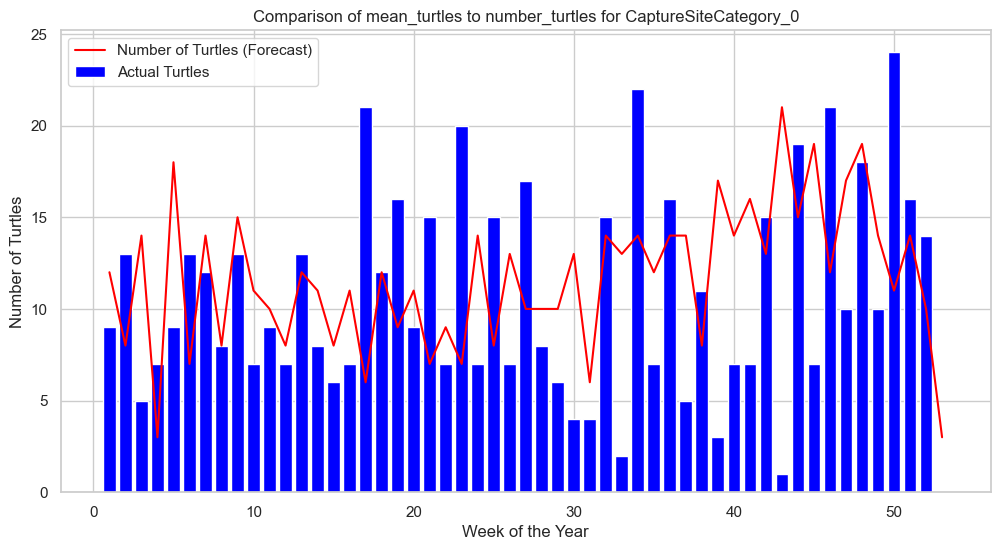

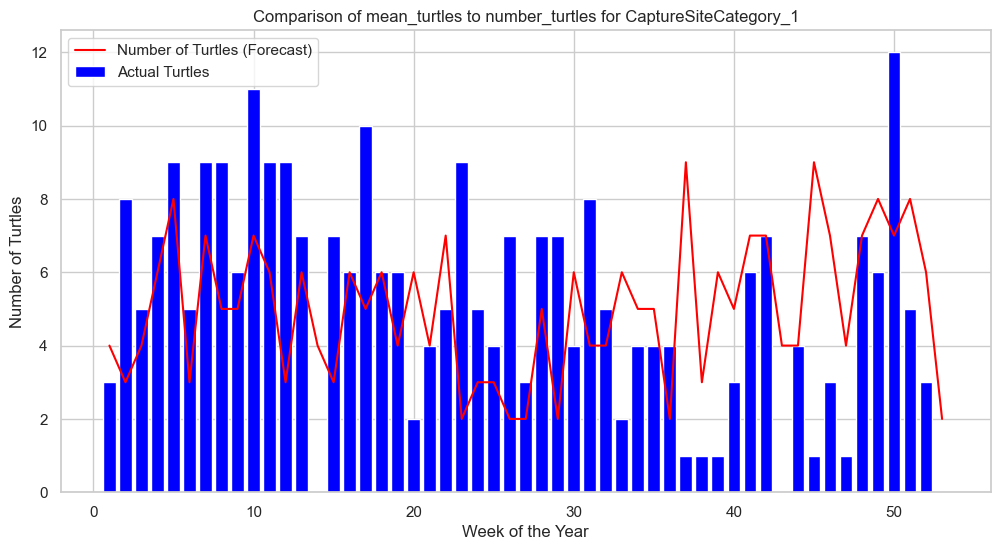

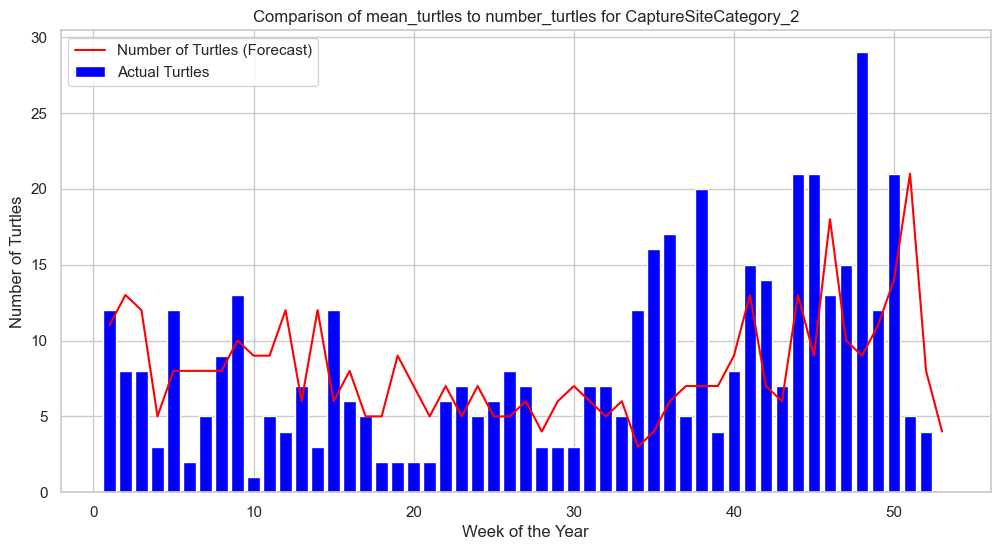

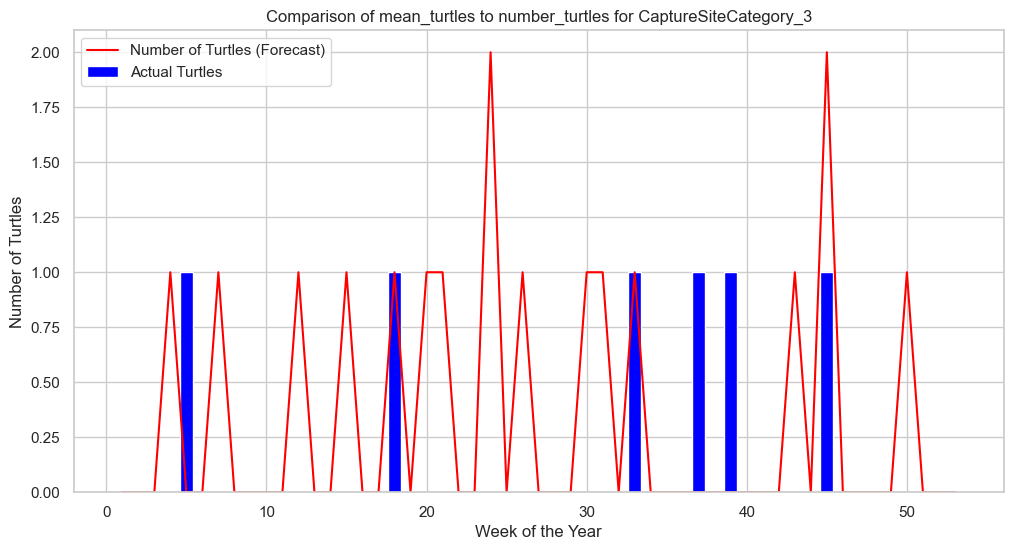

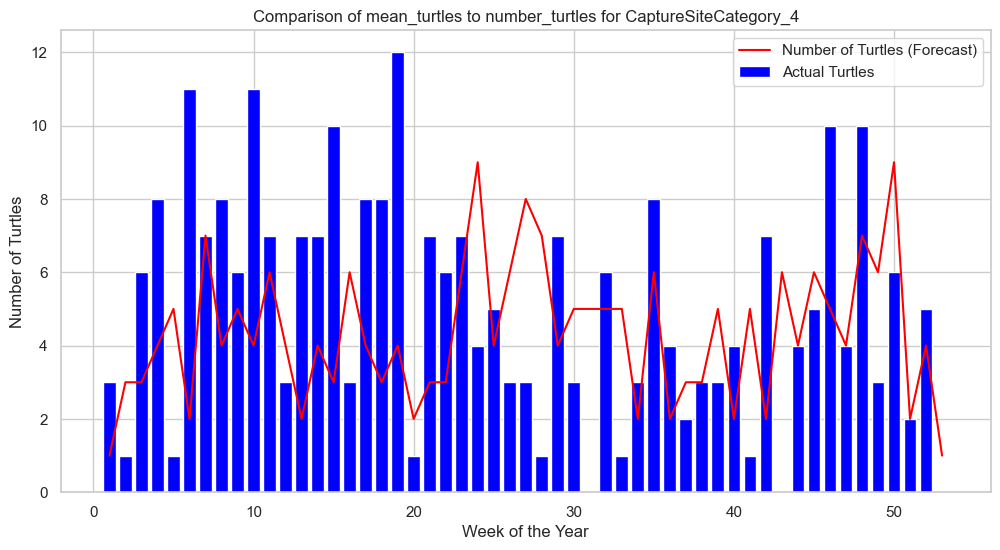

In [200]:
grouped = df.groupby('LandingSite')

# Plotting
for name, group in grouped:
    plt.figure(figsize=(12, 6))
    
    # Plotting mean_turtles as bar graph
    plt.bar(group['week_of_year'], group['actual_number'], color='blue', label='Actual Turtles')
    
    # Plotting number_turtles as line graph
    plt.plot(df.loc[df['LandingSite'] == name, 'week_of_year'], df.loc[df['LandingSite'] == name, 'mean_turtles_2015'], color='red', label='Number of Turtles (Forecast)')
    
    plt.title(f'Comparison of mean_turtles to number_turtles for {name}')
    plt.xlabel('Week of the Year')
    plt.ylabel('Number of Turtles')
    plt.legend()
    plt.grid(True)
    plt.show()


In [195]:
df

,week_of_year,LandingSite,actual_number,mean_turtles_2011,mean_turtles_2014,mean_turtles_2015,diff_2011,diff_2014,diff_2015
0,1,CaptureSiteCategory_0,9,15,14,12,-6,-5,-3
1,1,CaptureSiteCategory_1,3,5,4,4,-2,-1,-1
2,1,CaptureSiteCategory_2,12,9,10,11,3,2,1
3,1,CaptureSiteCategory_3,0,1,0,0,-1,0,0
4,1,CaptureSiteCategory_4,3,4,2,1,-1,1,2
...,...,...,...,...,...,...,...,...,...
260,53,CaptureSiteCategory_0,0,3,3,3,-3,-3,-3
261,53,CaptureSiteCategory_1,0,2,2,2,-2,-2,-2
262,53,CaptureSiteCategory_2,0,4,4,4,-4,-4,-4
263,53,CaptureSiteCategory_3,0,0,0,0,0,0,0


In [199]:
df[df['LandingSite'] == 'CaptureSiteCategory_0']

,week_of_year,LandingSite,actual_number,mean_turtles_2011,mean_turtles_2014,mean_turtles_2015,diff_2011,diff_2014,diff_2015
0,1,CaptureSiteCategory_0,9,15,14,12,-6,-5,-3
5,2,CaptureSiteCategory_0,13,18,16,8,-5,-3,5
10,3,CaptureSiteCategory_0,5,12,11,14,-7,-6,-9
15,4,CaptureSiteCategory_0,7,11,6,3,-4,1,4
20,5,CaptureSiteCategory_0,9,18,15,18,-9,-6,-9
25,6,CaptureSiteCategory_0,13,10,8,7,3,5,6
30,7,CaptureSiteCategory_0,12,12,12,14,0,0,-2
35,8,CaptureSiteCategory_0,8,12,8,8,-4,0,0
40,9,CaptureSiteCategory_0,13,15,14,15,-2,-1,-2
45,10,CaptureSiteCategory_0,7,12,12,11,-5,-5,-4


In [196]:
df.describe()

,week_of_year,actual_number,mean_turtles_2011,mean_turtles_2014,mean_turtles_2015,diff_2011,diff_2014,diff_2015
count,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000
mean,27.000000,5.890566,5.916981,5.988679,5.898113,-0.026415,-0.098113,-0.007547
std,15.326003,5.533584,4.390146,4.516370,4.637728,4.365331,4.237928,4.806082
min,1.000000,0.000000,0.000000,0.000000,0.000000,-17.000000,-17.000000,-20.000000
25%,14.000000,1.000000,3.000000,3.000000,2.000000,-2.000000,-2.000000,-2.000000
50%,27.000000,5.000000,5.000000,5.000000,5.000000,0.000000,0.000000,0.000000
75%,40.000000,8.000000,8.000000,8.000000,8.000000,2.000000,1.000000,2.000000
max,53.000000,29.000000,21.000000,18.000000,21.000000,19.000000,16.000000,20.000000


In [197]:
grouped = df.groupby('LandingSite')

for name, group in grouped:
    print(f"Summary statistics for {name}:")
    print(group.describe())
    print("\n")

Summary statistics for CaptureSiteCategory_0:
       week_of_year  actual_number  mean_turtles_2011  mean_turtles_2014   
count     53.000000      53.000000          53.000000          53.000000  \
mean      27.000000      10.641509          12.528302          11.981132   
std       15.443445       5.694445           3.220152           3.307861   
min        1.000000       0.000000           3.000000           3.000000   
25%       14.000000       7.000000          11.000000          10.000000   
50%       27.000000       9.000000          12.000000          12.000000   
75%       40.000000      15.000000          15.000000          14.000000   
max       53.000000      24.000000          21.000000          18.000000   

       mean_turtles_2015  diff_2011  diff_2014  diff_2015  
count          53.000000  53.000000  53.000000  53.000000  
mean           11.679245  -1.886792  -1.339623  -1.037736  
std             3.886731   6.103783   5.967680   7.057354  
min             3.000000 -17.

In [208]:
# Calculate RMSE
rmse_2015 = np.sqrt(mean_squared_error(df['actual_number'], df['mean_turtles_2015']))
# Calculate R-squared
r_squared_2015 = r2_score(df['actual_number'], df['mean_turtles_2015'])

# Calculate RMSE
rmse_2014 = np.sqrt(mean_squared_error(df['actual_number'], df['mean_turtles_2014']))
# Calculate R-squared
r_squared_2014 = r2_score(df['actual_number'], df['mean_turtles_2014'])

# Calculate RMSE
rmse_2011 = np.sqrt(mean_squared_error(df['actual_number'], df['mean_turtles_2011']))
# Calculate R-squared
r_squared_2011 = r2_score(df['actual_number'], df['mean_turtles_2011'])


print(f"RMSE (2015): {rmse_2015}")
print(f"R-squared (2015): {r_squared_2015}")

print(f"RMSE (2014): {rmse_2014}")
print(f"R-squared (2014): {r_squared_2014}")

print(f"RMSE (2011): {rmse_2011}")
print(f"R-squared (2011): {r_squared_2011}")



RMSE (2015): 4.797011648382457
R-squared (2015): 0.2456542623659449
RMSE (2014): 4.23106213526259
R-squared (2014): 0.413149199846514
RMSE (2011): 4.357167160022365
R-squared (2011): 0.37764621088275974


In [209]:
df_no3 = df[df['LandingSite'] != 'CaptureSiteCategory_3']
df_no3

,week_of_year,LandingSite,actual_number,mean_turtles_2011,mean_turtles_2014,mean_turtles_2015,diff_2011,diff_2014,diff_2015
0,1,CaptureSiteCategory_0,9,15,14,12,-6,-5,-3
1,1,CaptureSiteCategory_1,3,5,4,4,-2,-1,-1
2,1,CaptureSiteCategory_2,12,9,10,11,3,2,1
4,1,CaptureSiteCategory_4,3,4,2,1,-1,1,2
5,2,CaptureSiteCategory_0,13,18,16,8,-5,-3,5
...,...,...,...,...,...,...,...,...,...
259,52,CaptureSiteCategory_4,5,4,4,4,1,1,1
260,53,CaptureSiteCategory_0,0,3,3,3,-3,-3,-3
261,53,CaptureSiteCategory_1,0,2,2,2,-2,-2,-2
262,53,CaptureSiteCategory_2,0,4,4,4,-4,-4,-4


In [210]:
# Calculate RMSE
rmse_2015_no3 = np.sqrt(mean_squared_error(df_no3['actual_number'], df_no3['mean_turtles_2015']))
# Calculate R-squared
r_squared_2015_no3 = r2_score(df_no3['actual_number'], df_no3['mean_turtles_2015'])

# Calculate RMSE
rmse_2014_no3 = np.sqrt(mean_squared_error(df_no3['actual_number'], df_no3['mean_turtles_2014']))
# Calculate R-squared
r_squared_2014_no3 = r2_score(df_no3['actual_number'], df_no3['mean_turtles_2014'])

# Calculate RMSE
rmse_2011_no3 = np.sqrt(mean_squared_error(df_no3['actual_number'], df_no3['mean_turtles_2011']))
# Calculate R-squared
r_squared_2011_no3 = r2_score(df_no3['actual_number'], df_no3['mean_turtles_2011'])


print(f"RMSE (2015): {rmse_2015_no3}")
print(f"R-squared (2015): {r_squared_2015_no3}")

print(f"RMSE (2014): {rmse_2014_no3}")
print(f"R-squared (2014): {r_squared_2014_no3}")

print(f"RMSE (2011): {rmse_2011_no3}")
print(f"R-squared (2011): {r_squared_2011_no3}")

RMSE (2015): 5.354860250453488
R-squared (2015): -0.0360951593076666
RMSE (2014): 4.719489898883181
R-squared (2014): 0.19518977755374212
RMSE (2011): 4.854000489773047
R-squared (2011): 0.148660088708374


# Baseline Model: 
Training Data 2014-2017; Test Data 2018

Means of Turtle Capture by Week-of-Year per 5 LandingSites

RMSE (2014): 4.23106213526259

R-squared (2014): 0.413149199846514

In [211]:
df

,week_of_year,LandingSite,actual_number,mean_turtles_2011,mean_turtles_2014,mean_turtles_2015,diff_2011,diff_2014,diff_2015
0,1,CaptureSiteCategory_0,9,15,14,12,-6,-5,-3
1,1,CaptureSiteCategory_1,3,5,4,4,-2,-1,-1
2,1,CaptureSiteCategory_2,12,9,10,11,3,2,1
3,1,CaptureSiteCategory_3,0,1,0,0,-1,0,0
4,1,CaptureSiteCategory_4,3,4,2,1,-1,1,2
...,...,...,...,...,...,...,...,...,...
260,53,CaptureSiteCategory_0,0,3,3,3,-3,-3,-3
261,53,CaptureSiteCategory_1,0,2,2,2,-2,-2,-2
262,53,CaptureSiteCategory_2,0,4,4,4,-4,-4,-4
263,53,CaptureSiteCategory_3,0,0,0,0,0,0,0
